In [2]:
#
import numpy as np
import os, sys

sys.path.insert(0, '/global/homes/q/qmxp55/DESI/bgstargets/py')

from io_ import get_sweep_whole, getBGSbits, flux_to_mag
from io_ import get_random, get_isdesi, get_dict, bgsmask, get_reg, get_svfields, gaiaAEN
from cuts import getGeoCuts, bgsbut
from QA import getStats, flow, mollweide, mycmap, plot_sysdens, overdensity, hexbin

from QA import set_mwd, get_radec_mw
from io_ import get_isdes

import healpy as hp
import astropy.io.fits as fits
import fitsio
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib
from astropy.coordinates import SkyCoord
import astropy.units as units
from astropy.table import Table

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

``` python 
import glob
files = sorted(glob.glob(os.path.join('/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/dr9-south_sweep_whole_r21.0', '*.npy')))

catdict = {}
        
for i in files:
    catdict[i] = np.load(i, mmap_mode='r+')

df = np.concatenate(tuple(catdict.values()))



files = sorted(glob.glob(os.path.join('/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/dr9-south_sweep_whole_r21.0', '*.npy')))
for num, i in enumerate(files):
    print(i)
    tab2 = getBGSbits(mycatpath=i, outdir='/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/bgsbits/tmp_%i' %(num), mycat=True, getmycat=True, tractor=False)
    del tab2
```

In [3]:
#
#import h5py
import glob

#f1 = h5py.File("/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/data.hdf5", "w")
files = sorted(glob.glob(os.path.join('/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/bgsbits', '*.npy')))
A = np.load(files[0])
cols = A.dtype.names
tab = Table()

# for col in cols:
#     cat0 = []
#     for num, i in enumerate(files):
#         cat = np.load(i)
#         cat0 += cat[col].tolist()
    
#     #f1.create_dataset(col, dtype=A.dtype[col], data=cat0)
#     tab[col] = cat0
#     del cat0, cat
#     print(col)
    
#f1.close()

In [4]:
cols

('RELEASE',
 'BRICKID',
 'BRICKNAME',
 'OBJID',
 'TYPE',
 'RA',
 'DEC',
 'GMAG',
 'RMAG',
 'ZMAG',
 'FLUX_IVAR_G',
 'FLUX_IVAR_R',
 'FLUX_IVAR_Z',
 'NOBS_G',
 'NOBS_R',
 'NOBS_Z',
 'FRACFLUX_G',
 'FRACFLUX_R',
 'FRACFLUX_Z',
 'FRACMASKED_G',
 'FRACMASKED_R',
 'FRACMASKED_Z',
 'FRACIN_G',
 'FRACIN_R',
 'FRACIN_Z',
 'SHAPE_R',
 'SHAPE_R_IVAR',
 'SHAPE_E1',
 'SHAPE_E1_IVAR',
 'SHAPE_E2',
 'SHAPE_E2_IVAR',
 'RFIBERMAG',
 'REF_CAT',
 'REF_ID',
 'G',
 'AEN',
 'MASKBITS',
 'FITBITS',
 'SERSIC',
 'SERSIC_IVAR',
 'FLUX_R',
 'BGSBITS')

In [2]:
#

import glob
files = sorted(glob.glob(os.path.join('/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/dr9-south_sweep_whole_r21.0', '*.npy')))
cols = np.load(files[0]).dtype.names
cat0 = {i:[] for i in cols}
cat0

# for num, i in enumerate(files):
#     cat = np.load(i)
#     print(num)
#     for j in cols:
#         cat0[j] += cat[j].tolist()
        

{'RELEASE': [],
 'BRICKID': [],
 'BRICKNAME': [],
 'OBJID': [],
 'TYPE': [],
 'RA': [],
 'DEC': [],
 'FLUX_G': [],
 'FLUX_R': [],
 'FLUX_Z': [],
 'FLUX_IVAR_G': [],
 'FLUX_IVAR_R': [],
 'FLUX_IVAR_Z': [],
 'MW_TRANSMISSION_G': [],
 'MW_TRANSMISSION_R': [],
 'MW_TRANSMISSION_Z': [],
 'NOBS_G': [],
 'NOBS_R': [],
 'NOBS_Z': [],
 'FRACFLUX_G': [],
 'FRACFLUX_R': [],
 'FRACFLUX_Z': [],
 'FRACMASKED_G': [],
 'FRACMASKED_R': [],
 'FRACMASKED_Z': [],
 'FRACIN_G': [],
 'FRACIN_R': [],
 'FRACIN_Z': [],
 'SHAPE_R': [],
 'SHAPE_R_IVAR': [],
 'SHAPE_E1': [],
 'SHAPE_E1_IVAR': [],
 'SHAPE_E2': [],
 'SHAPE_E2_IVAR': [],
 'FIBERFLUX_R': [],
 'REF_CAT': [],
 'REF_ID': [],
 'GAIA_PHOT_G_MEAN_MAG': [],
 'GAIA_ASTROMETRIC_EXCESS_NOISE': [],
 'MASKBITS': [],
 'FITBITS': [],
 'SERSIC': [],
 'SERSIC_IVAR': []}

In [6]:
!ls /global/cfs/cdirs/desi/target/catalogs/dr9m/0.44.0/pixweight/main/resolve/bright

pixweight-bright.fits


In [2]:
#
dr = 'dr9'
survey = 'north' #is either south (DECaLS+DES) or north (BASS/MzLS)
version = '0.1.0'
filesdir = '/global/cscratch1/sd/qmxp55/bgstargets_output/'
Nranfiles = 3
reg = 'north'
dec_resol_ns = 32.375
if (dr == 'dr9sv'): Nranfiles = 20 # because the randoms for dr9d have a density of 100000 = 5000*20

pathdir = os.path.abspath(os.getcwd())+'/%s-%s_%s_%s_sv_plots' %(dr, survey, reg, version)
ispathdir = os.path.isdir(pathdir)
if not ispathdir: os.mkdir(pathdir)

# for healpy
dr8pix     = '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/pixweight/pixweight-dr8-0.31.1.fits'
dr9pix = '/global/cfs/cdirs/desi/target/catalogs/dr9m/0.44.0/pixweight/main/resolve/bright/pixweight-bright.fits'

if dr[:3] == 'dr8': pixfile = dr8pix
elif dr[:3] == 'dr9': pixfile = dr9pix
    
hdr          = fits.getheader(pixfile,1)
nside,nest   = hdr['hpxnside'],hdr['hpxnest']
npix         = hp.nside2npix(nside)
pixarea      = hp.nside2pixarea(nside,degrees=True)

In [3]:
#load catalogues
if dr == 'dr9sv': N = 1
else: N = Nranfiles
    
cat = np.load(filesdir+dr+'/'+version+'/'+'bgstargets-'+survey+'.npy')
cat_ex = np.load(filesdir+dr+'/'+version+'/'+'extra-'+survey+'_n256.npy')
ran = np.load(filesdir+dr+'/'+dr+'_random_N'+str(N)+'.npy', mmap_mode='r+')
ran_ex = np.load(filesdir+dr+'/'+'extra_random_N'+str(N)+'_n256.npy', mmap_mode='r+')

In [4]:
hppix_ran = ran_ex['hppix']
ranindesi = ran_ex['desi']
raninreg = (ran_ex[reg]) & (ran_ex['desi'])

hppix_cat = cat_ex['hppix']
catindesi = cat_ex['desi']
catinreg = (cat_ex[reg]) & (cat_ex['desi'])


## Filter catalogue and randoms by region

In [5]:
#RANDOMS
keep = raninreg
ran = ran[keep]
ran_ex = ran_ex[keep]
ranindesi = ranindesi[keep]
hppix_ran = hppix_ran[keep]
raninreg = raninreg[keep]

#CATALOGUE
keepC = catinreg
cat = cat[keepC]
cat_ex = cat_ex[keepC]
catindesi = catindesi[keepC]
hppix_cat = hppix_cat[keepC]
catinreg = catinreg[keepC]


In [6]:
#bgsmask = bgsmask()
rancuts = getGeoCuts(ran, randoms=True)

## getting area of reg with healpix pixels (for flow charts...)

NOTE: if using SVFIELDS footprint, use `desifootprint=False` otherwise the area will be less than the current SVFIELDS due desi footprint chops out part of it.

In [7]:
#Notes: This hpdict is used to get the area only using the randoms. 
#This use the randoms within the DESI footprint and without any masking (maskrand=None) as we want the area without wholes.
hpdict0 = get_dict(cat=None, pixmapfile=pixfile, hppix_ran=hppix_ran, hppix_cat=None, 
                      maskrand=None, maskcat=None, Nranfiles=Nranfiles, ranindesi=ranindesi, catindesi=None, 
                            desifootprint=True, namesels=None, target_outputs=False, log=True)

positions and desifotprint DONE...
systematics DONE...
randdens =  15000  ; len randoms =  68240287
bgsfracarea DONE...
regions DONE...
area_all = 4549 deg2
bgsarea_south = 0 deg2
bgsarea_decals = 0 deg2
bgsarea_des = 0 deg2
bgsarea_north = 4549 deg2
bgsarea_south_n = 0 deg2
bgsarea_south_s = 0 deg2
bgsarea_svfields = 358 deg2
bgsarea_svfields_n = 358 deg2
bgsarea_svfields_s = 0 deg2
areas DONE...


## Healpy pixels catalogue with BGS target density (for dens. sky maps and systematics plots...)

In [9]:
#from astropy.coordinates import SkyCoord
#import astropy.units as units

#c = SkyCoord(cat['RA']*units.degree,cat['DEC']*units.degree, frame='icrs')
#galb = c.galactic.b.value # galb coordinate

In [8]:
#dic with default BGS selection and in DESI footprint
hpdict = get_dict(cat=cat, pixmapfile=dr8pix, hppix_ran=hppix_ran, hppix_cat=hppix_cat, 
                      maskrand=((rancuts['BS']) & (rancuts['GC']) & (rancuts['nobs'])),
                          maskcat=None, 
                             Nranfiles=Nranfiles, ranindesi=ranindesi, catindesi=None, 
                                desifootprint=True, namesels={'bgs_sv_any':30, 'bgs_sv_bright':31, 'bgs_sv_faint':32, 'bgs_sv_faint_ext':33, 'bgs_sv_fibmag':34, 'bgs_sv_lowq':35, 'bgs_sv_lowq_wqc':37}, 
                                  galb=cat_ex['b'], log=True, survey='bgs')

positions and desifotprint DONE...
systematics DONE...
randdens =  15000  ; len randoms =  68240287
bgsfracarea DONE...
regions DONE...
area_all = 4493 deg2
bgsarea_south = 0 deg2
bgsarea_decals = 0 deg2
bgsarea_des = 0 deg2
bgsarea_north = 4493 deg2
bgsarea_south_n = 0 deg2
bgsarea_south_s = 0 deg2
bgsarea_svfields = 354 deg2
bgsarea_svfields_n = 354 deg2
bgsarea_svfields_s = 0 deg2
areas DONE...
computing for  north / bgs_sv_any
computing for  north / bgs_sv_bright
computing for  north / bgs_sv_faint
computing for  north / bgs_sv_faint_ext
computing for  north / bgs_sv_fibmag
computing for  north / bgs_sv_lowq
computing for  north / bgs_sv_lowq_wqc
target densities in north DONE...
computing for  south / bgs_sv_any
computing for  south / bgs_sv_bright
computing for  south / bgs_sv_faint
computing for  south / bgs_sv_faint_ext
computing for  south / bgs_sv_fibmag
computing for  south / bgs_sv_lowq
computing for  south / bgs_sv_lowq_wqc
target densities in south DONE...
meandens_bgs_sv

## BGS outline

In [11]:
#
sv = {}

sv['bgs_sv_any'] = ((cat['BGSBITS'] & 2**(30)) != 0)
sv['bgs_sv_bright'] = ((cat['BGSBITS'] & 2**(31)) != 0)
sv['bgs_sv_faint'] = ((cat['BGSBITS'] & 2**(32)) != 0)
sv['bgs_sv_faint_ext'] = ((cat['BGSBITS'] & 2**(33)) != 0)
sv['bgs_sv_fibmag'] = ((cat['BGSBITS'] & 2**(34)) != 0)
sv['bgs_sv_lowq'] = ((cat['BGSBITS'] & 2**(35)) != 0)
sv['bgs_sv_lowq_wqc'] = ((cat['BGSBITS'] & 2**(37)) != 0)

print('mean density of BGS SV: \t %.2f' %(hpdict['meandens_bgs_sv_any_'+survey]))
print('Area within BGS SV: \t %.2f' %(hpdict['bgsarea_'+survey]))

print('No & density of BGS SV galaxies:')
for key, val in zip(sv.keys(), sv.values()):
    print('\t %s: \t %i \t %.2f [1/deg^2]' %(key, np.sum(val), np.sum(val)/hpdict['bgsarea_'+survey]))

print('Overall density of BGS SV:')
for key in sv.keys():
    print('\t %s: \t %.2f [1/deg^2]' %(key, hpdict['dens_'+key+'_'+survey]))

print('BGS SV density by model fitted:')
print('------------------------------------')
for morph in list(set(cat['TYPE'][:10000])):
    
    keep = cat['TYPE'] == morph
    print('%s: \t %.2f(b) \t %.2f(f) \t %.2f(fe) \t %.2f(fibmag) \t %.2f(lowq) \t %.2f(lowq_wqc)' 
          %(morph, 
           np.sum((keep) & (sv['bgs_sv_bright']))/hpdict['bgsarea_'+survey],
           np.sum((keep) & (sv['bgs_sv_faint']))/hpdict['bgsarea_'+survey],
           np.sum((keep) & (sv['bgs_sv_faint_ext']))/hpdict['bgsarea_'+survey],
           np.sum((keep) & (sv['bgs_sv_fibmag']))/hpdict['bgsarea_'+survey],
           np.sum((keep) & (sv['bgs_sv_lowq']))/hpdict['bgsarea_'+survey],
           np.sum((keep) & (sv['bgs_sv_lowq_wqc']))/hpdict['bgsarea_'+survey]
           ))


mean density of BGS SV: 	 2502.00
Area within BGS SV: 	 4493.09
No & density of BGS SV galaxies:
	 bgs_sv_any: 	 11121282 	 2475.20 [1/deg^2]
	 bgs_sv_bright: 	 3820292 	 850.26 [1/deg^2]
	 bgs_sv_faint: 	 3351327 	 745.89 [1/deg^2]
	 bgs_sv_faint_ext: 	 2822779 	 628.25 [1/deg^2]
	 bgs_sv_fibmag: 	 918773 	 204.49 [1/deg^2]
	 bgs_sv_lowq: 	 208111 	 46.32 [1/deg^2]
	 bgs_sv_lowq_wqc: 	 449617 	 100.07 [1/deg^2]
Overall density of BGS SV:
	 bgs_sv_any: 	 2474.84 [1/deg^2]
	 bgs_sv_bright: 	 850.26 [1/deg^2]
	 bgs_sv_faint: 	 745.89 [1/deg^2]
	 bgs_sv_faint_ext: 	 628.25 [1/deg^2]
	 bgs_sv_fibmag: 	 204.49 [1/deg^2]
	 bgs_sv_lowq: 	 45.96 [1/deg^2]
	 bgs_sv_lowq_wqc: 	 99.71 [1/deg^2]
BGS SV density by model fitted:
------------------------------------
PSF: 	 6.22(b) 	 3.11(f) 	 0.00(fe) 	 22.06(fibmag) 	 3.13(lowq) 	 7.35(lowq_wqc)
REX: 	 128.99(b) 	 205.95(f) 	 169.12(fe) 	 117.81(fibmag) 	 19.71(lowq) 	 38.41(lowq_wqc)
EXP: 	 81.24(b) 	 159.53(f) 	 218.89(fe) 	 17.20(fibmag) 	 17.61(

In [13]:
Ared = hpdict['bgsarea_'+reg]

## BGS dens. sky maps

In [14]:
from QA import mollweide, mycmap, plot_sysdens
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib

In [21]:
keys = list(sv.keys())
print(keys)

['bgs_sv_any', 'bgs_sv_bright', 'bgs_sv_faint', 'bgs_sv_faint_ext', 'bgs_sv_fibmag', 'bgs_sv_lowq', 'bgs_sv_lowq_wqc']


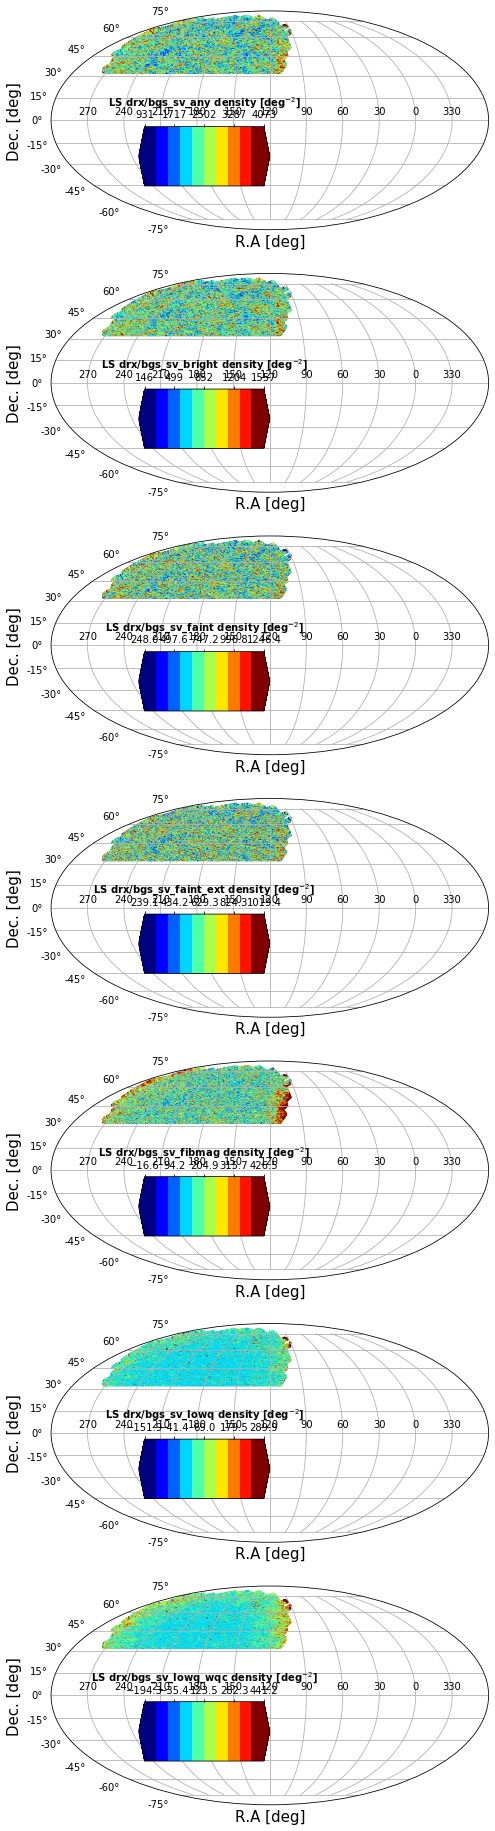

In [22]:
#
keys = list(sv.keys())
fig = plt.figure(figsize=(15,33))
gs = gridspec.GridSpec(len(keys),1)
    
org          = 120  # centre ra for mollweide plots
projection   = 'mollweide'
cm = mycmap(matplotlib.cm.jet, 10,0,1)
cmr= mycmap(matplotlib.cm.jet_r,10,0,1)

for num, key in enumerate(keys):
    mollweide(hpdict=hpdict, namesel=key, reg=reg, projection=projection, n=num, org=org, cm=cm, fig=fig, gs=gs, cval=None)
#mollweide(hpdict=hpdict, namesel='bgs_sv_faint', reg=reg, projection=projection, n=1, org=org, cm=cm, fig=fig, gs=gs, cval=None)
#mollweide(hpdict=hpdict, namesel='bgs_sv_faint_ext', reg=reg, projection=projection, n=2, org=org, cm=cm, fig=fig, gs=gs, cval=None)
#mollweide(hpdict=hpdict, namesel='bgs_sv_fibmag', reg=reg, projection=projection, n=3, org=org, cm=cm, fig=fig, gs=gs, cval=None)
#mollweide(hpdict=hpdict, namesel='bgs_sv_lowq', reg=reg, projection=projection, n=4, org=org, cm=cm, fig=fig, gs=gs, cval=None)
#mollweide(hpdict=hpdict, C=None ,namesel='any', reg='all', projection=projection, n=1, org=org, cm=cm, 
#          fig=fig, ws=ws, perc=(0.3,99.8), title='After linear weights', cval=(84, 2750))

file = '%s/skydens_%s_%s' %(pathdir, dr, reg)
fig.savefig(file+'.png', bbox_inches = 'tight', pad_inches = 0)


## r-mag vs rfibmag & star-galaxy separation plots with main differences between nominal and SV selection

In [23]:
def draw_arrow(x0, y0, x1, y1, lab, xc, yc, ax):
    
    ax.annotate("", xy=(x0, y0), xytext=(x1, y1),
             arrowprops=dict(arrowstyle="<|-|>", connectionstyle="arc3"))
    #"<->"

    ax.text(xc, yc, lab,
         {'color': 'black', 'fontsize': 14, 'ha': 'center', 'va': 'center',
          'bbox': dict(boxstyle="round", fc="white", ec="black", pad=0.2)})
    

In [24]:
bgs_any = ((cat['BGSBITS'] & 2**(20)) != 0)
sg = ((cat['BGSBITS'] & 2**(6)) == 0) & (cat['RMAG'] < 20)
Grr = cat['G'] - flux_to_mag(cat['FLUX_R'])
inGAIA = cat['REF_CAT'] == 'G2'
contourBGS = {'g-z':cat['GMAG'][bgs_any & inGAIA] - cat['ZMAG'][bgs_any & inGAIA], 'G-rr':Grr[bgs_any & inGAIA]}
contourStars = {'g-z':cat['GMAG'][sg & inGAIA] - cat['ZMAG'][sg & inGAIA], 'G-rr':Grr[sg & inGAIA]}

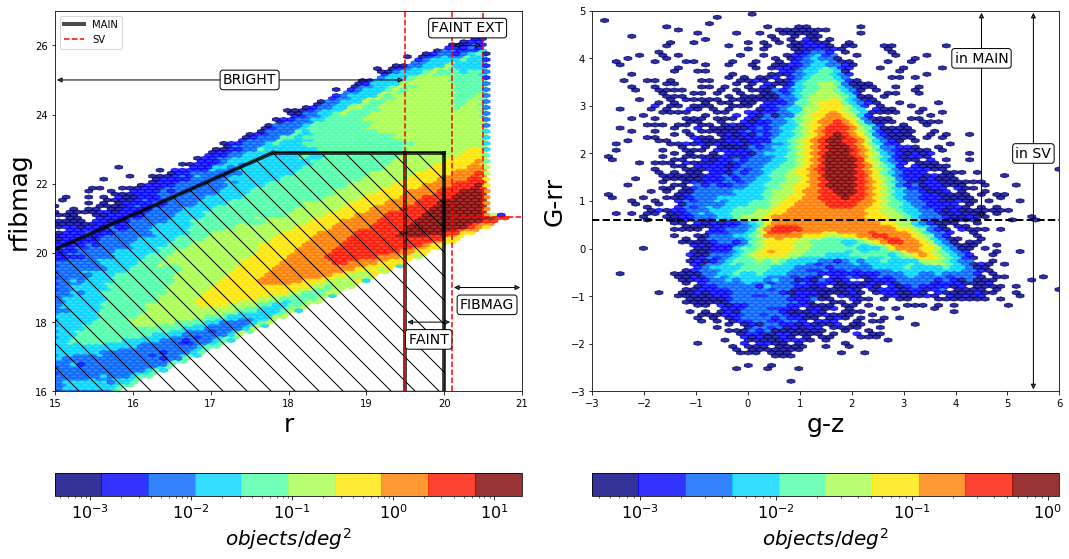

In [29]:
#
#Grr = cat['G'] - flux_to_mag(cat['FLUX_R'])
coord2 = {'g-z':cat['GMAG'] - cat['ZMAG'], 'G-rr':Grr}
coord1 = {'r':cat['RMAG'], 'rfibmag':cat['RFIBERMAG']}
mask = (catinreg) & (sv['bgs_sv_any']) #& (cat['TYPE'] == 'REX')
cmap = plt.get_cmap('jet', 10)

fig   = plt.figure(figsize=(18,10))
gs     = gridspec.GridSpec(1, 2, hspace=0.2, wspace=0.15)

ax = hexbin(coord=coord1, C=np.full(len(mask), 1/Ared), clab='$objects/deg^{2}$', catmask=mask, n=0, bins='log', title=None, cmap=cmap, 
               ylab=True, vline=None, hline=None, fig=fig, gs=gs, xlim=(15, 21), ylim=(16, 27), 
                   vmin=None, vmax=None, mincnt=1, fmcline=False,
                       file=None, fracs=False, area=Ared, cbar='horizontal', reduce_C_function=np.sum)

#ax = fig.add_subplot(gs[0])
ax.plot(np.full(3, 19.5),np.linspace(16, 22.9, 3), ls='-', lw=4, c='k', alpha=0.7, label='MAIN')
ax.plot(np.full(3, 20),np.linspace(16, 22.9, 3), ls='-', lw=4, c='k', alpha=0.7)

ax.axvline(19.5, ls='--', c='r', label='SV')
ax.axvline(20.1, ls='--', c='r')
ax.plot(np.linspace(20.1, 21, 3), np.full(3, 21.051), ls='--', c='r')
ax.plot(np.full(3, 20.5), np.linspace(21.051, 27, 3), ls='--', c='r')

#NOMINAL FMC line:
delta = 1.0
x1 = np.linspace(15, 18.8-delta, 4)
x2 = np.linspace(18.8-delta, 20, 4)
plt.plot(x2, x2*0+22.9, color='k', ls='-', lw=4, alpha=0.7)
plt.plot(x1, 2.9 + 1.2 + delta + x1, color='k', ls='-', lw=4, alpha=0.7)

#hatch
plt.fill([15, 20, 20, 17.8, 15], [16, 16, 22.9, 22.9, 20.1], fill=False, hatch='\\')
#plt.fill(x2, x2*0+22.9, fill=False, hatch='\\')

#draw arrows    
draw_arrow(15, 25, 19.5, 25, 'BRIGHT', 17.5, 25, ax)
draw_arrow(19.5, 18, 20.1, 18, 'FAINT', 19.8, 17.5, ax)
draw_arrow(20.1, 26, 20.5, 26, 'FAINT EXT', 20.3, 26.5, ax)
draw_arrow(20.1, 19, 21, 19, 'FIBMAG', 20.55, 18.5, ax)

ax.legend()

#''' 
ax = hexbin(coord=coord2, C=np.full(len(mask), 1/Ared), clab='$objects/deg^{2}$', catmask=mask, n=1, bins='log', title=None, cmap=cmap, 
               ylab=True, vline=None, hline=None, fig=fig, gs=gs, xlim=(-3, 6), ylim=(-3, 5), 
                   vmin=None, vmax=None, mincnt=1, fmcline=False,
                       file=None, fracs=False, area=Ared, cbar='horizontal', plothist=False, reduce_C_function=np.sum) 

#contour1=contourBGS, contour2=contourStars, levels1=(2, 1000, 10000), levels2=(200, 1000, 10000)

#ax = fig.add_subplot(gs[1])
ax.axhline(0.6, ls='--', lw=2, c='k', alpha=1)
#draw arrows    
draw_arrow(4.5, 0.6, 4.5, 5, 'in MAIN', 4.5, 4, ax)
draw_arrow(5.5, -3, 5.5, 5, 'in SV', 5.5, 2, ax)
#'''

file='%s/r_rfibmag_hexbin_svss_%s' %(pathdir, survey)
fig.savefig(file, bbox_inches = 'tight', pad_inches = 0)


## Flow charts: Nominal & Galaxy View

In [30]:
#use below code to get target densities of keep and rejected at a particular stage in flowchart...
#use hpdict0 if density computed over the total area (before applyin spatial cuts in randoms)
#use hpdict if density computed over the reduced area (after applying spatial cuts in randoms)
if True:
    bgslist_WQC = ['BS', 'GC', 'nobs', 'SGSV', 'CC', 'QC_FM', 'QC_FI', 'QC_FF']
    
    t = getStats(cat=cat, hpdict=hpdict0, bgsmask=bgsmask(), rancuts=rancuts, CurrentMask=['QC_FM', 'QC_FI', 'QC_FF'], 
             PrevMask=['BS', 'GC', 'nobs', 'SGSV', 'CC'], 
                 reg=reg, regcat=catinreg, regran=raninreg)

Previous Cuts: (BS|GC|nobs|SGSV|CC)
Current Cuts: (QC_FM|QC_FI|QC_FF)


In [31]:
t

<Table length=6>
          GM          $f_{A}$ [$\%$] $\eta_{B}$ [deg$^2$] $\eta_{F}$ [deg$^2$]
       bytes21           float64           float64              float64       
--------------------- -------------- -------------------- --------------------
                QC_FM            0.0                21.67                 4.62
                QC_FI            0.0                 0.27                 0.11
                QC_FF            0.0                24.52                11.09
  (QC_FM|QC_FI|QC_FF)            0.0                34.34                14.59
~(QC_FM|QC_FI|QC_FF)*          98.76               805.42               567.05
 ~(QC_FM|QC_FI|QC_FF)          98.76               815.51               574.15

In [34]:
if reg == 'south': surveylab = 'DECaLS+DES'
elif reg == 'north': surveylab = 'BASS_MzLS'
elif reg == 'desi': surveylab = 'DESI'
else: surveylab = reg
    
flowTitle = dr+'_'+surveylab

#this is important to read the area of the proper region in hpdict0
region = reg

Previous Cuts: (None)
Current Cuts: (BS|GC)
Previous Cuts: (BS|GC)
Current Cuts: (nobs)
Previous Cuts: (BS|GC|nobs)
Current Cuts: (SGSV)
Previous Cuts: (BS|GC|nobs|SGSV)
Current Cuts: (CC)
Previous Cuts: (BS|GC|nobs|SGSV|CC)
Current Cuts: (QC_FM|QC_FI|QC_FF)


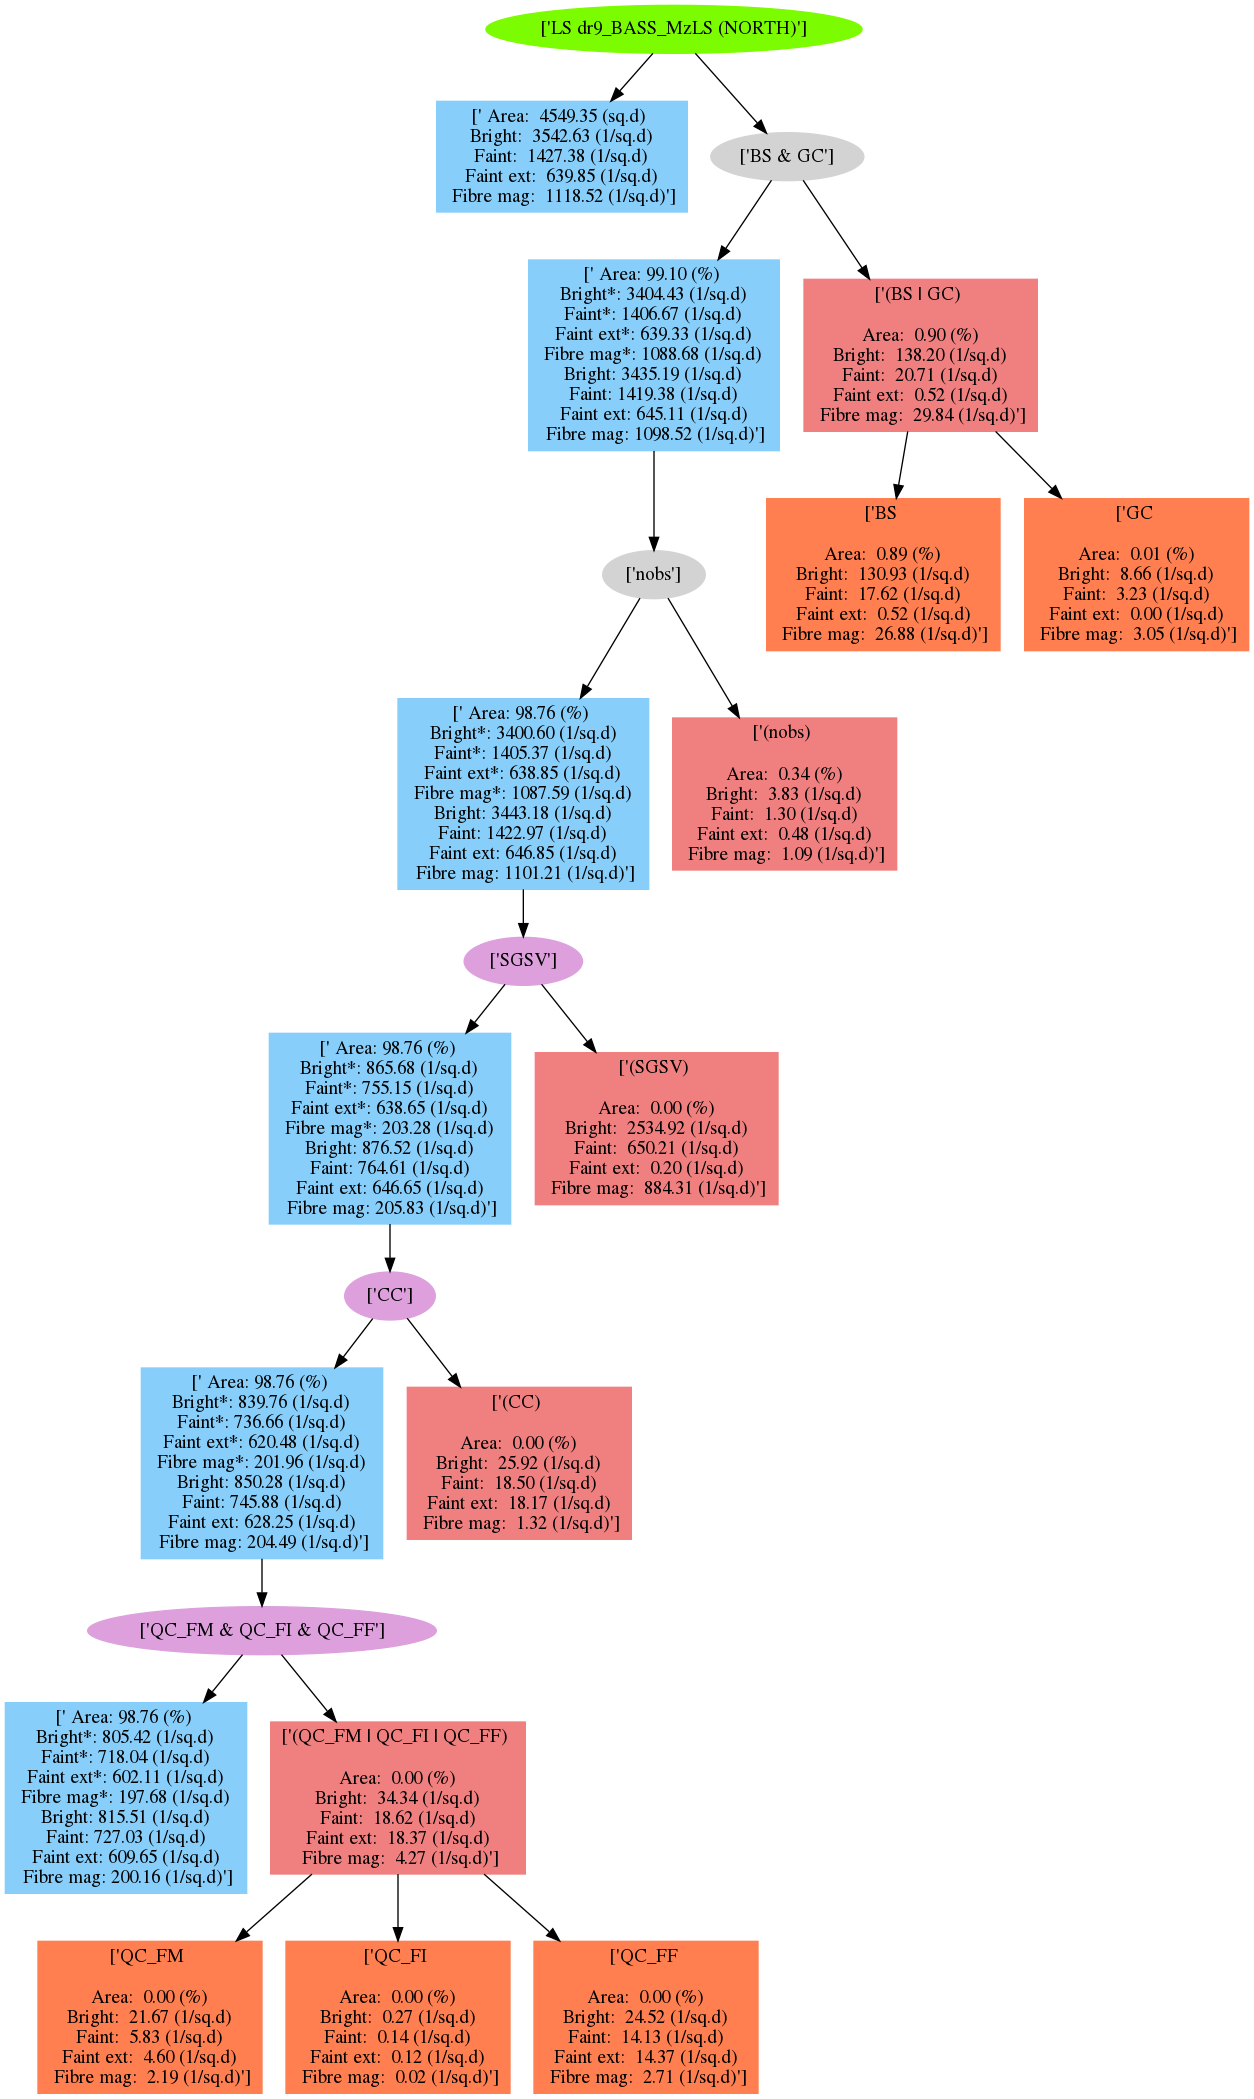

In [35]:
order = [['BS', 'GC'], ['nobs'], ['SGSV'], ['CC'], ['QC_FM', 'QC_FI', 'QC_FF']]


flowNominal, _, _ = flow(cat=cat, hpdict=hpdict0, bgsmask=bgsmask(), rancuts=rancuts, order=order, reg=region, 
             regcat=catinreg, regran=raninreg, file='%s/flow_main_sv_%s' %(pathdir, flowTitle), dr=flowTitle, program='sv')

flowNominal

## 2D-stacks around Bright Stars and Medium Stars

Firs we do the stacking around the bright stars (`BS mask`) using BGS but `BS`. 

For the second stacking, we use BGS and do the stacking around the Medium Stars (`MS mask`).

In [19]:
#star catalogue
stars = np.load('/global/cscratch1/sd/qmxp55/pauline/stars_GAIA_TYCHO_13.npy')

In [20]:
hppix_stars = hp.ang2pix(nside,(90.-stars['DEC'])*np.pi/180.,stars['RA']*np.pi/180.,nest=True) # catalogue hp pixels array
starsinreg = get_reg(reg=reg, hppix=hppix_stars)
#cstars = SkyCoord(stars['RA']*units.degree,stars['DEC']*units.degree, frame='icrs')
#galb_stars = cstars.galactic.b.value # galb coordinate
stars = stars[(starsinreg) & (stars['DEC'] > -25)]

8.00 < MAG < 12.00
mag_radii MAX: 98.43467880720439 mag_radii MIN: 29.01009464736186
mag MAX: 11.999996185302734 mag MIN: 8.000004768371582
d2d min=0.00134, d2d max=13.8
density cumu (min, max): (nan, nan)
density non-cumu (min, max): (-3.2, 0.877)
9 of inf in density ratio out of a total of 16977
Minimum density ratio = -6.90478, Maximum density ratio = 3.47352
----------------
12.00 < MAG < 13.00
mag_radii MAX: 29.010044635122284 mag_radii MIN: 21.357112467941665
mag MAX: 12.99999713897705 mag MIN: 12.000001907348633
d2d min=0.00169, d2d max=18.7
density cumu (min, max): (nan, nan)
density non-cumu (min, max): (-6.43, 0.068)
21 of inf in density ratio out of a total of 16977
Minimum density ratio = -5.42856, Maximum density ratio = 0.761267
----------------


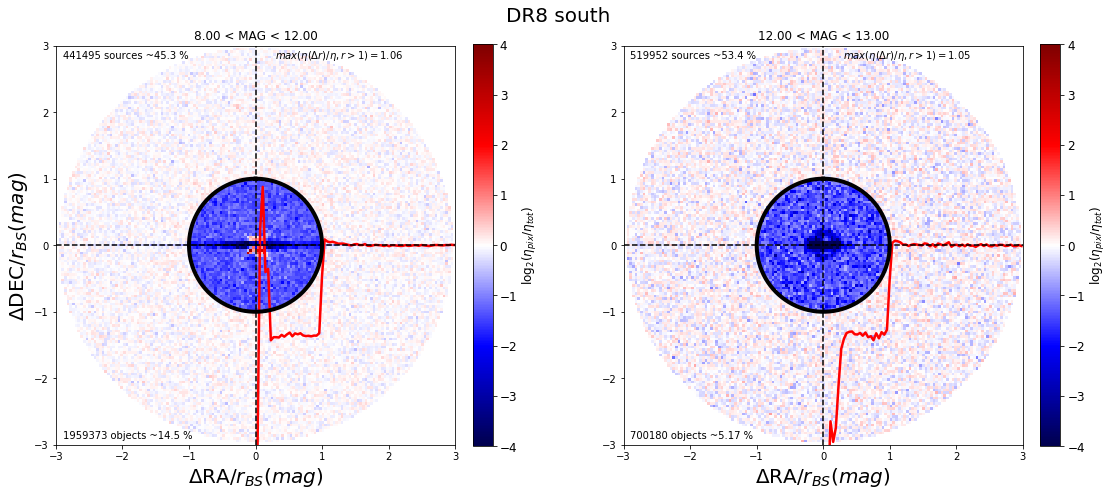

In [21]:
#
bgslist = ['LG', 'GC', 'nobs', 'SG', 'FMC2', 'CC', 'QC_FM', 'QC_FI', 'QC_FF']
    
# get BGS objects without BS bit set on
bgsbutBS = np.ones_like(cat['RA'], dtype=bool)

for key in bgslist:
    keep = ((cat['BGSBITS'] & 2**(bgsmask()[key])) != 0)
    bgsbutBS &= keep
bgsbutBS &= cat['RMAG'] < 20
    
log = True
nbins = 150
    
#Dustin_radii's
mag = np.linspace(0, 20, 50)
Dustin_MS_radii = []
for i,j in enumerate(mag):
    Dustin_MS_radii.append([j, np.minimum(1800., 150. * 2.5**((11. - j)/3.)) * 0.262/1])
        
plt.figure(figsize=(18, 8))
plt.title(r'DR8 %s' %(survey), size=20)
plt.axis('off')
_ = overdensity(cat[bgsbutBS], stars, Dustin_MS_radii, 'MAG', 35, density=False, 
                        magbins=[8,12,13], radii_2=None, grid=[1,2], SR=[0., 400.], scaling=True, nbins=nbins, 
                               SR_scaling=3,logDenRat=[-4, 4], radii_bestfit=False, annulus=None, bintype='0', 
                                   filename='%s/2d_stack_BS_DR8_%s' %(pathdir, survey), log=log)


In [44]:
from io_ import get_msmask

#load mask sources objects from SWEEPS DR8
masksources = np.load('/global/cscratch1/sd/qmxp55/sweep_files/dr8_sweep_whole_maskbitsource.npy')

In [45]:
#get the medium bright stars
starsMS = get_msmask(masksources)

6584 nearby objects
12378075 Bright Stars


In [50]:
hppix_starsMS = hp.ang2pix(nside,(90.-starsMS['DEC'])*np.pi/180.,starsMS['RA']*np.pi/180.,nest=True) # catalogue hp pixels array
starsMSinreg = get_reg(reg=reg, hppix=hppix_starsMS)
#cstars = SkyCoord(stars['RA']*units.degree,stars['DEC']*units.degree, frame='icrs')
#galb_stars = cstars.galactic.b.value # galb coordinate
starsMS = starsMS[(starsMSinreg) & (starsMS['DEC'] > -25)]

13.00 < MAG < 14.00
mag_radii MAX: 21.35708648417855 mag_radii MIN: 15.745247379763304
mag MAX: 13.999998092651367 mag MIN: 13.000000953674316
d2d min=0.000245, d2d max=6.35
density cumu (min, max): (nan, nan)
density non-cumu (min, max): (-inf, 0.0381)
60 of inf in density ratio out of a total of 16977
Minimum density ratio = -5.48684, Maximum density ratio = 0.779947
----------------
14.00 < MAG < 15.00
mag_radii MAX: 15.745225034392389 mag_radii MIN: 11.599834873836398
mag MAX: 14.999999046325684 mag MIN: 14.00000286102295
d2d min=0.000349, d2d max=8.62
density cumu (min, max): (nan, nan)
density non-cumu (min, max): (-inf, 0.0598)
69 of inf in density ratio out of a total of 16977
Minimum density ratio = -5.46748, Maximum density ratio = 0.817921
----------------
15.00 < MAG < 16.00
mag_radii MAX: 11.599827908139646 mag_radii MIN: 8.544484463674413
mag MAX: 15.999999046325684 mag MIN: 15.000000953674316
d2d min= 0, d2d max=11.7
density cumu (min, max): (nan, nan)
density non-cumu (

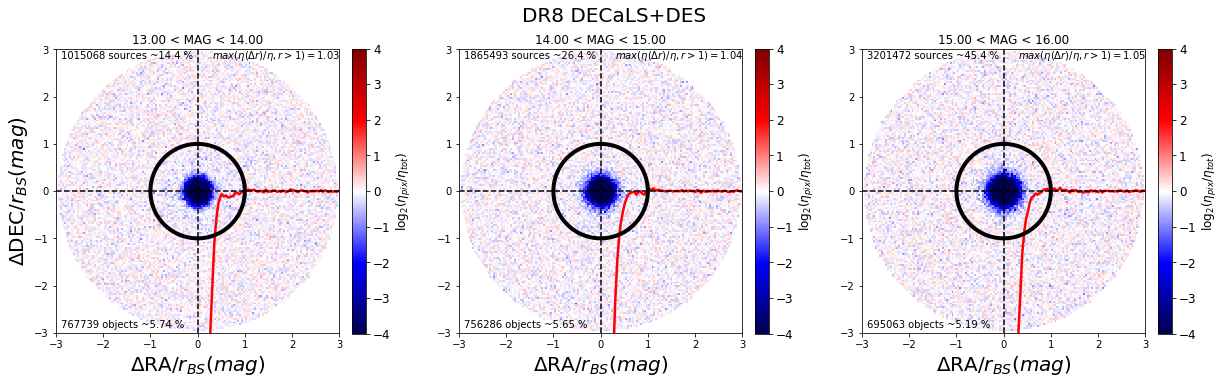

In [59]:
log = True
nbins = 150

bgs_any = ((cat['BGSBITS'] & 2**(20)) != 0)
        
plt.figure(figsize=(20, 6))
plt.title(r'DR8 %s' %(survey), size=20)
plt.axis('off')
_ = overdensity(cat[bgs_any], starsMS, Dustin_MS_radii, 'MAG', 35, density=False, 
                        magbins=[13,14,15,16], radii_2=None, grid=[1,3], SR=[2., 100.], scaling=True, nbins=nbins, 
                               SR_scaling=3,logDenRat=[-4, 4], radii_bestfit=False, annulus=None, bintype='0', 
                                   filename='%s/2d_stack_MS_DR8_%s' %(pathdir, survey), log=log)

## Grr vs g-z: bgsbutSG

In [22]:
#bgslist = ['BS', 'LG', 'GC', 'nobs', 'FMC2', 'CC', 'QC_FM', 'QC_FI', 'QC_FF', 'QC_IVAR']
    
## get BGS objects without BS bit set on
#bgsbutSG = np.ones_like(cat['RA'], dtype=bool)

#for key in bgslist:
#    keep = ((cat['BGSBITS'] & 2**(bgsmask()[key])) != 0)
#    bgsbutSG &= keep
#bgsbutSG &= cat['RMAG'] < 20

bgsbutSG = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['SG'], bgsmask=bgsmask(), rlimit=20)

finite = np.ones_like(cat['RMAG'], dtype='?')
for i in ['RMAG', 'GMAG', 'ZMAG','FLUX_R', 'RFIBERMAG']:
    finite &= np.isfinite(cat[i])
    

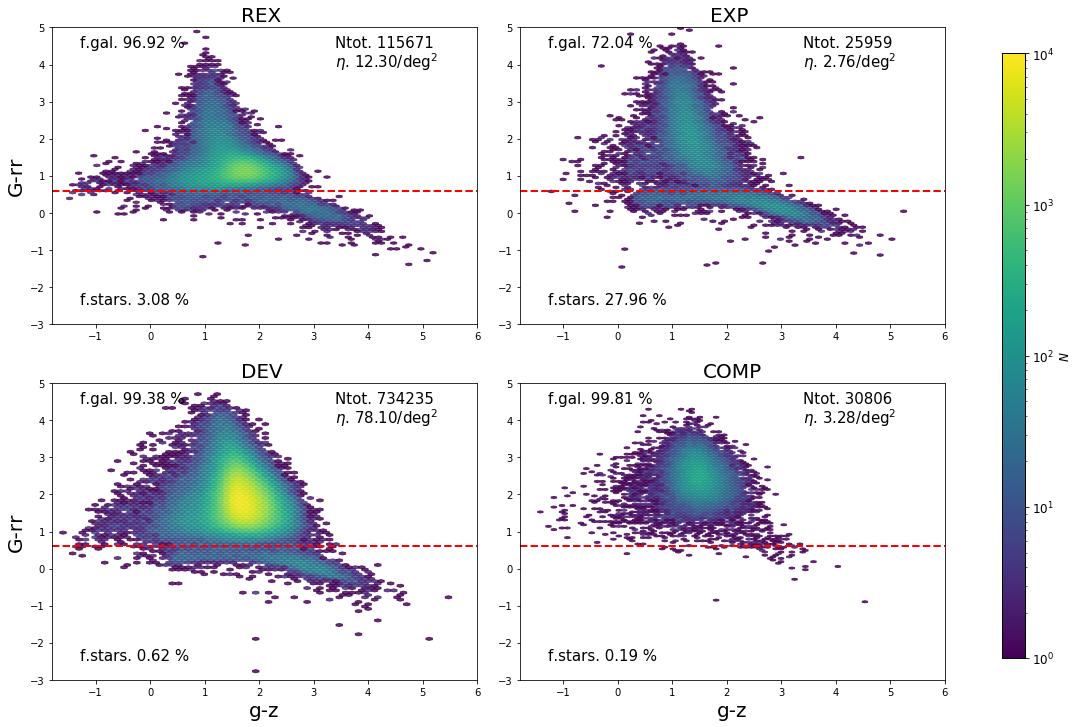

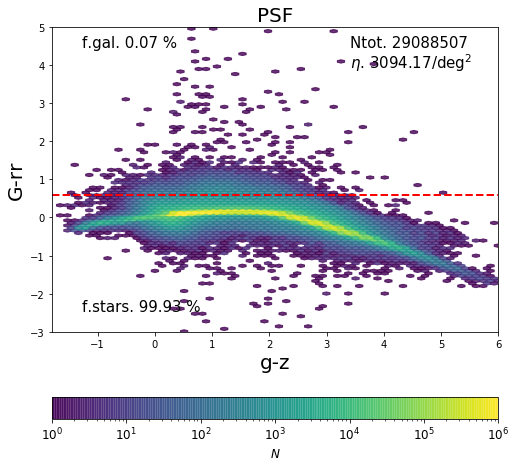

In [24]:
#
Grr = cat['G'] - flux_to_mag(cat['FLUX_R'])
coord = {'g-z':cat['GMAG'] - cat['ZMAG'], 'G-rr':Grr}
morphos = ['REX ', 'EXP ', 'DEV ', 'COMP']
rows, cols = 2, 2
#debug = cat['RMAG'] < 16
mask = (catinreg) & (bgsbutSG) & (finite) #& (debug)
hline, vline = 0.6, None
vmin, vmax = 1, None
    
fig    = plt.figure(figsize=(8*cols,6*rows))
gs     = gridspec.GridSpec(rows, cols, hspace=0.2, wspace=0.10)
    
for i, morpho in enumerate(morphos):
        
    if (i%cols==0): ylab=True
    else: ylab = False
    if morpho == 'PSF ': 
        vmax, cbar = None, 'vertical'
    else:
        vmax, cbar = 10000, 'panel'
        
    if i < 2: xlab = False
    else: xlab = True
        
    morphomask = cat['TYPE'] == morpho
    hexbin(coord=coord, catmask=((mask) & (morphomask)), n=i, bins='log', title=morpho, cmap='viridis', 
               ylab=ylab, xlab=xlab, vline=vline, hline=hline, fig=fig, gs=gs, vmin=vmin, vmax=vmax, mincnt=1, 
                   file='%s/gz_Grr_bgsbutSG_hexbin_extended_%s' %(pathdir, survey), fracs=True, area=Ared, cbar=cbar)

fig    = plt.figure(figsize=(8*1,8*1))
gs     = gridspec.GridSpec(1, 1, hspace=0.15, wspace=0.10)

hexbin(coord=coord, catmask=((mask) & (cat['TYPE'] == 'PSF ')), n=0, bins='log', title='PSF', cmap='viridis', 
               ylab=True, vline=vline, hline=hline, fig=fig, gs=gs, vmin=None, vmax=1000000, mincnt=1, 
                   file='%s/gz_Grr_bgsbutSG_hexbin_psf_%s' %(pathdir, survey), fracs=True, area=Ared, cbar='horizontal')
        

## rmag vs rfibmag: bgsbutFMC

In [25]:
#bgslist = ['BS', 'LG', 'GC', 'nobs', 'SG', 'CC', 'QC_FM', 'QC_FI', 'QC_FF', 'QC_IVAR']
    
## get BGS objects without BS bit set on
#bgsbutFMC2 = np.ones_like(cat['RA'], dtype=bool)

#for key in bgslist:
#    keep = ((cat['BGSBITS'] & 2**(bgsmask()[key])) != 0)
#    bgsbutFMC2 &= keep
#bgsbutFMC2 &= cat['RMAG'] < 20

bgsbutFMC2 = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['FMC2'], bgsmask=bgsmask(), rlimit=20)


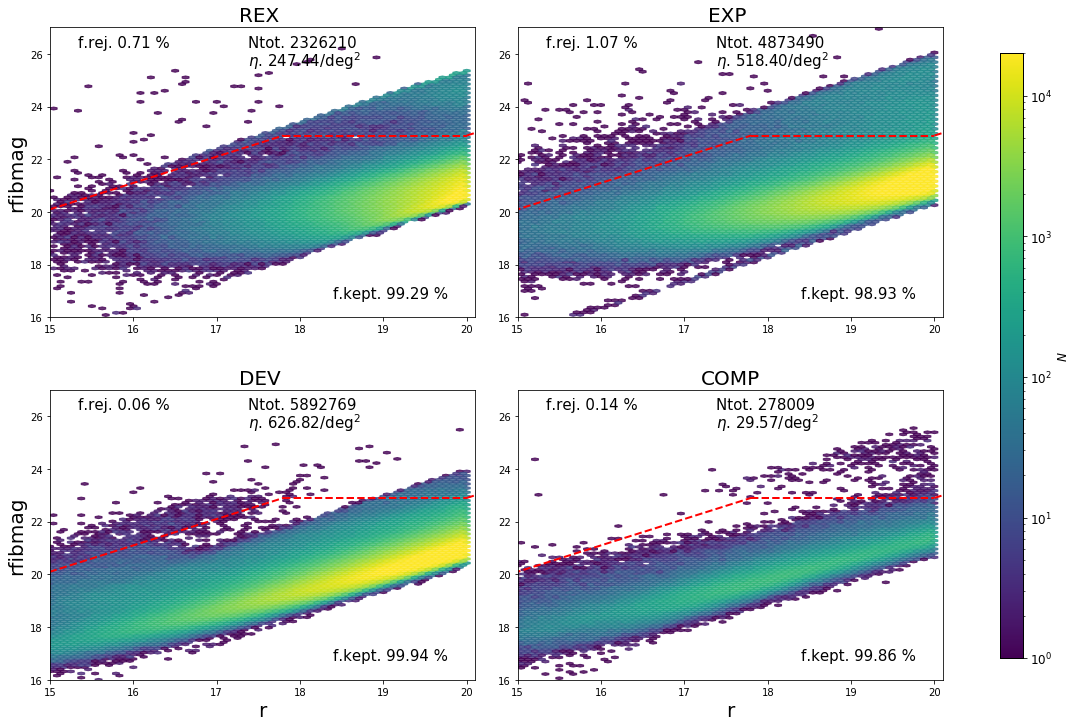

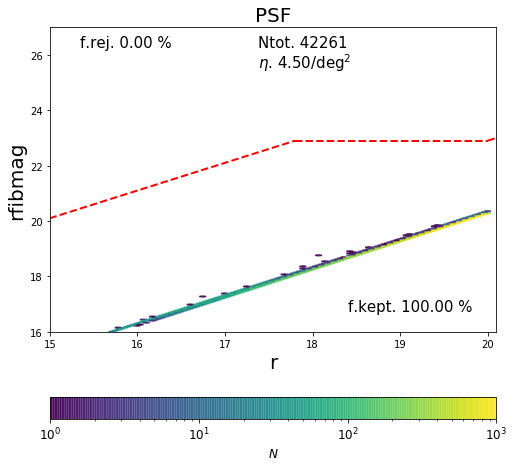

In [26]:
#
rows, cols = 2, 2
coord = {'r':cat['RMAG'], 'rfibmag':cat['RFIBERMAG']}
morphos = ['REX ', 'EXP ', 'DEV ', 'COMP']
#debug = cat['RMAG'] < 16
mask = (catinreg) & (bgsbutFMC2) & (finite) #& (debug)
hline, vline = None, None
vmin, vmax = 1, 20000
    
fig    = plt.figure(figsize=(8*cols,6*rows))
gs     = gridspec.GridSpec(rows, cols, hspace=0.25, wspace=0.10)
    
for i, morpho in enumerate(morphos):
        
    if (i%cols==0): ylab=True
    else: ylab = False
    if morpho == 'PSF ': 
        vmax, cbar = None, 'vertical'
    else:
        vmax, cbar = 20000, 'panel'
        
    if i < 2: xlab = False
    else: xlab = True
        
    morphomask = cat['TYPE'] == morpho
    hexbin(coord=coord, catmask=((mask) & (morphomask)), n=i, bins='log', title=morpho, cmap='viridis', 
               ylab=ylab, xlab=xlab, vline=vline, hline=hline, fig=fig, gs=gs, vmin=vmin, vmax=vmax, mincnt=1, fmcline=True, 
                   file='%s/r_rfibmag_bgsbutFMC2_hexbin_extended_%s' %(pathdir, survey), fracs=False, area=Ared, cbar=cbar)
    
    
fig    = plt.figure(figsize=(8*1,8*1))
gs     = gridspec.GridSpec(1, 1, hspace=0.15, wspace=0.10)

hexbin(coord=coord, catmask=((mask) & (cat['TYPE'] == 'PSF ')), n=0, bins='log', title='PSF', cmap='viridis', 
               ylab=True, vline=vline, hline=hline, fig=fig, gs=gs, vmin=None, vmax=1000, mincnt=1, fmcline=True,
                   file='%s/r_rfibmag_bgsbutFMC2_hexbin_psf_%s' %(pathdir, survey), fracs=False, area=Ared, cbar='horizontal')
        

## g-r vs r-z: bgsbutCC

In [27]:

bgsbutCC = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['CC'], bgsmask=bgsmask(), rlimit=20)


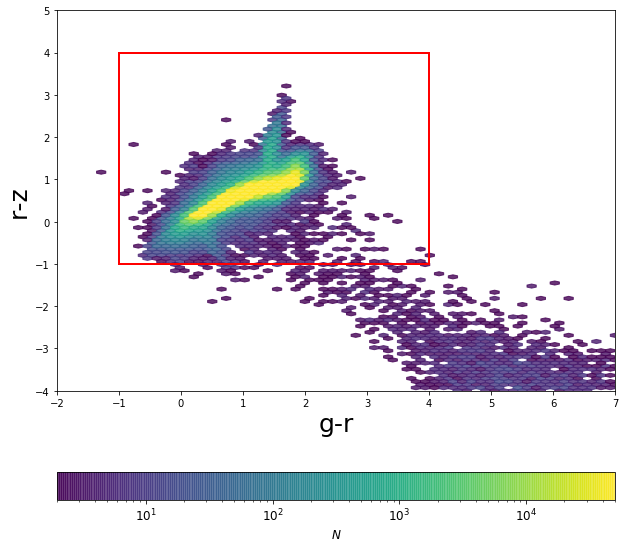

In [60]:
#
import matplotlib.patches as patches

coord = {'g-r':cat['GMAG'] - cat['RMAG'], 'r-z':cat['RMAG'] - cat['ZMAG']}
mask = (catinreg) & (bgsbutCC) & (finite) # & (cat['RMAG'] < 14)

fig   = plt.figure(figsize=(10,10))
gs     = gridspec.GridSpec(1, 1, hspace=0.15, wspace=0.10)


hexbin(coord=coord, catmask=mask, n=0, bins='log', title=None, cmap='viridis', 
               ylab=True, vline=None, hline=None, fig=fig, gs=gs, xlim=(-2, 7), ylim=(-4, 5), 
                   vmin=None, vmax=50000, mincnt=2, fmcline=False,
                       file=None, fracs=False, area=Ared, cbar='horizontal')

plt.plot(np.linspace(-1, 4, 3), np.full(3, -1), lw=2, c='r')
plt.plot(np.linspace(-1, 4, 3), np.full(3, 4), lw=2, c='r')

plt.plot(np.full(3, -1), np.linspace(-1, 4, 3), lw=2, c='r')
plt.plot(np.full(3, 4), np.linspace(-1, 4, 3), lw=2, c='r')

file='%s/gr_rz_bgsbutCC_hexbin_%s' %(pathdir, survey)
fig.savefig(file, bbox_inches = 'tight', pad_inches = 0)



In [ ]:
#
#Grr = cat['G'] - flux_to_mag(cat['FLUX_R'])
coord2 = {'g-z':cat['GMAG'] - cat['ZMAG'], 'G-rr':Grr}
coord1 = {'r':cat['RMAG'], 'rfibmag':cat['RFIBERMAG']}
mask = (catinreg) & (sv['bgs_sv_any']) #& (cat['TYPE'] == 'COMP')
cmap = plt.get_cmap('viridis', 10)

fig   = plt.figure(figsize=(10,10))
gs     = gridspec.GridSpec(1, 1, hspace=0.2, wspace=0.15)

ax = hexbin(coord=coord1, C=np.full(len(mask), 1/Ared), clab='$objects/deg^{2}$', catmask=mask, n=0, bins='log', title=None, cmap=cmap, 
               ylab=True, vline=None, hline=None, fig=fig, gs=gs, xlim=(15, 21), ylim=(16, 27), 
                   vmin=None, vmax=None, mincnt=1, fmcline=False,
                       file=None, fracs=False, area=Ared, cbar='horizontal', reduce_C_function=np.sum)

#ax = fig.add_subplot(gs[0])
ax.plot(np.full(3, 19.5),np.linspace(16, 22.9, 3), ls='-', lw=4, c='k', alpha=0.7, label='MAIN')
ax.plot(np.full(3, 20),np.linspace(16, 22.9, 3), ls='-', lw=4, c='k', alpha=0.7)

ax.axvline(19.5, ls='--', c='r', label='SV')
ax.axvline(20.1, ls='--', c='r')
ax.plot(np.linspace(20.1, 21, 3), np.full(3, 21.051), ls='--', c='r')
ax.plot(np.full(3, 20.5), np.linspace(21.051, 27, 3), ls='--', c='r')

#NOMINAL FMC line:
delta = 1.0
x1 = np.linspace(15, 18.8-delta, 4)
x2 = np.linspace(18.8-delta, 20, 4)
plt.plot(x2, x2*0+22.9, color='k', ls='-', lw=4, alpha=0.7)
plt.plot(x1, 2.9 + 1.2 + delta + x1, color='k', ls='-', lw=4, alpha=0.7)

#hatch
plt.fill([15, 20, 20, 17.8, 15], [16, 16, 22.9, 22.9, 20.1], fill=False, hatch='\\')
#plt.fill(x2, x2*0+22.9, fill=False, hatch='\\')

#draw arrows    
draw_arrow(15, 25, 19.5, 25, 'BRIGHT', 17.5, 25, ax)
draw_arrow(19.5, 18, 20.1, 18, 'FAINT', 19.8, 17.5, ax)
draw_arrow(20.1, 26, 20.5, 26, 'FAINT EXT', 20.3, 26.5, ax)
draw_arrow(20.1, 19, 21, 19, 'FIBMAG', 20.55, 18.5, ax)

ax.tick_params(axis='both', labelsize=16)
ax.legend()

file='%s/r_rfibmag_svss_%s' %(pathdir, survey)
fig.savefig(file, bbox_inches = 'tight', pad_inches = 0)


x max: 309033.0
y max: 140801.0


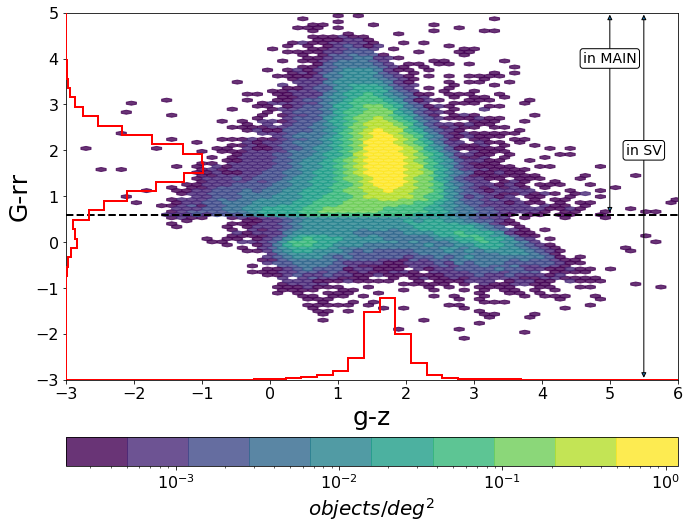

In [51]:
#''' 
fig   = plt.figure(figsize=(10,6))
gs     = gridspec.GridSpec(1, 1, hspace=0.2, wspace=0.15)
cmap = plt.get_cmap('viridis', 10)

mask = (catinreg) & (sv['bgs_sv_any']) #& (cat['TYPE'] == 'COMP')

ax1 = hexbin(coord=coord2, C=np.full(len(mask), 1/Ared), clab='$objects/deg^{2}$', catmask=mask, n=0, bins='log', title=None, cmap=cmap, 
               ylab=True, vline=None, hline=None, fig=fig, gs=gs, xlim=(-3, 6), ylim=(-3, 5), 
                   vmin=None, vmax=None, mincnt=1, fmcline=False,
                       file=None, fracs=False, area=Ared, cbar='horizontal', plothist=True, reduce_C_function=np.sum) 
#contour1=contourBGS, contour2=contourStars, levels1=(2, 1000, 10000), levels2=(200, 1000, 10000)

#ax = fig.add_subplot(gs[1])
ax1.axhline(0.6, ls='--', lw=2, c='k', alpha=1)
#draw arrows    
draw_arrow(5.0, 0.6, 5.0, 5, 'in MAIN', 5.0, 4, ax1)
draw_arrow(5.5, -3, 5.5, 5, 'in SV', 5.5, 2, ax1)
ax1.tick_params(axis='both', labelsize=16)
#ax1.set_xticklabels(fontsize=18)
#'''

file='%s/gz_Grr_svss_%s' %(pathdir, survey)
fig.savefig(file, bbox_inches = 'tight', pad_inches = 0)

CAPTION: 
Comparison between BGS SV selection and main selection as of DECaLS/DR8. Left: $r$-band total magnitude vs. $r$-band fiber magnitude showing 4 out of 5 disjoint BGS SV super sets in red dashed lines and main selection in hatched black. Right: $g-z$ vs. {\it GAIA} $G$-band minus $r$-band total magnitude not corrected for extinction used to classify stars and galaxies in BGS main selection. The object is defined as a galaxy if above threshold of $G-rr = 0.6$ (dashed-black line), while in SV BGS allows all the extended fitted objects (i.e., no PSF) below this threshold. Solid-black and solid-red contours are BGS main objects and stars using BGS star/galaxy classification down to $r = 20$ respectively.

TEXT:
The BGS main selection is mainly defined by cuts in the $r$-band total magnitude and in $r$-band fiber magnitude as it is shown in left plot of Figure~\ref{fig:r_rfibmag_hexbin_svss_south} (hatched black). For SV/BGS selection, it ignores upper cut in fibre magnitude from main selection, this cut was tuned using GAMA but since GAMA is complete to $r_{PETRO} = 19.8$ it could be the case that we are loosing galaxies in that region. it is known that high $r$-band fibre magnitues can get us poor redshift success rates, however, allowing this region to be targetted by SV will give us a better threshold than one we could achieve using GAMA. Stars and galaxies in BGS are defined using {\it GAIA} (Ruiz et. al. in prep.). The main selection classify an object that lies above {\it GAIA} $G$ minus $r$ mag with no extinction correction ($G-rr=0.6$) or if this is not in {\it GAiA} as a galaxy (see righ hand-side plot of Figure~\ref{fig:r_rfibmag_hexbin_svss_south}). If the object is below this threshold and it is in {\it GAIA} then it is classified as a star. This method allows to have BGS galaxies fitted by a PSF model or viceversa, having stars fitted by extended models. In SV, we extend this selection to include all the extended objects that lies below this threshold. The large galaxy geometric mask applied in the main selection is not longer applied on SV as these acount for much less than $1\%$. BGS define $5$ supersets that, besides previous discussed differences with main selection, follows:

\begin{itemize}
\item Bright ($r$ < $19.5$): same as bright sample in MAIN selection in $r$ magnitude and the most important sample for BGS. We fully sample this superset so as to be able fully explore completeness as a function of galaxy properties and environment. A high sparse sample of $540$ objects/deg$^2$.
\item Faint ($19.5$ < $r$ < $20.1$):  Essentially the BGS second priority sample but going $0.1$ $r$ mag deeper to capture the regime where we expect falling redshift success. We sparse sample to $300$ objects/deg$^2$ to reflect the greater importance of the main sample.
\end{itemize}

Potential faint sample substitutes:

\begin{itemize}
\item Faint extended ($20.1 < r < 20.5$ and $r$fibermag $>21.051$): A sparse sampled of $150$ objects/deg$^2$ fainter extension which will help probe whether there are subsets of this data (e.g. satisfying colour constraints) for which redshift completeness remains high.
\item Fiber magnitude ($r>20.1$ and $r$fibermag $<21.051$): A sparse sample of $150$ objects/deg$^2$ limited by fibre magnitude. To this limit there are $\sim 600$ objects/deg$^2$ fainter that $r=19.5$ and so this is a possible substitute for the standard faint sample and we will check that its redshift completeness remains high.
\item Low-quality ($r < 20.1$): A sparse sampled of $60$ objects/deg$^2$ These are the same quality cuts as currently defined for MAIN BGS target selection, the use of these flags has been demonstrated to remove mainly junk, but tuning of the thresholds is still under consideration.
\end{itemize}

The second in priority of BGS target selection correspond to the faint sample which does not have explicit requirements for BGS. Our goal is to maximize the overall scientific value of the sample, which will depend heavily but not exclusively on its spectroscopic redshift completeness.  Using SV data, we will investigate which galaxies that are not in BGS bright and have $r < 20.0$ have the lowest redshift success for our selected baseline exposure time and which galaxies with $r > 20$ have the highest redshift success. We will then consider swaps of galaxies from second set for galaxies from the first set.  We will accept such swaps if they noticeably increase the expected redshift completeness of BGS faint without significantly degrading its scientific value, e.g. by making clustering analyses difficult because of complex criteria or by omitting scientifically important classes of galaxies.
We will also consider the addition of galaxy subsets that have lower redshift completeness but particularly high scientific value, e.g., for probing the properties and clustering of low luminosity galaxies.

Our underlying goal with flags and masks is to avoid wasting fibers on galaxies that we would eventually have to remove from the sample for clustering analysis because of incompleteness or contamination.  
Other than star/galaxy classification, we will scrutinize any flag or mask that excludes more than $1\%$ of galaxies that would otherwise satisfy the target selection criteria.  If the contaminant fraction of these flagged/masked galaxies is below $20\%$, then we will restore these galaxies (or relax the flag/mask criterion).  
We will consider the default star/galaxy classification criteria acceptable if the stellar contamination fraction for the combined BGS sample is below $2\%$.  Otherwise we will consider more restrictive criteria, considering the tradeoff between missed galaxies and wasted fibers.



## Venn diagrams: QCs

In [14]:
from QA import plot_venn3

In [17]:
# get BGS but QCs
bgsbutQCs = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['QC_FM', 'QC_FI', 'QC_FF'], bgsmask=bgsmask(), rlimit=20)
FM = ((cat['BGSBITS'] & 2**(11)) == 0) #rejects by FM
FI = ((cat['BGSBITS'] & 2**(12)) == 0) #rejects by FI
FF = ((cat['BGSBITS'] & 2**(13)) == 0) #rejects by FF
area = hpdict0['bgsarea_south']

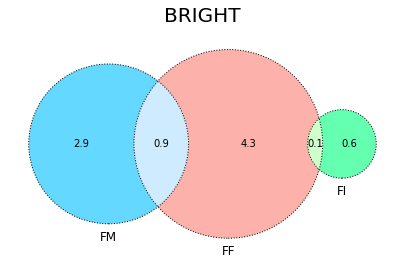

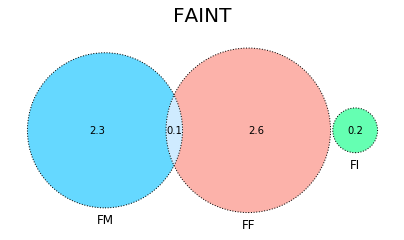

In [35]:
#
keepB = (bgsbutQCs) & (cat['RMAG'] < 19.5)
keepF = (bgsbutQCs) & (cat['RMAG'] > 19.5) & (cat['RMAG'] < 20)
plot_venn3(A=(keepB & FM), B=(keepB & FI), C=(keepB & FF), norm=area, 
           labels=['FM', 'FI', 'FF'], file=pathdir+'/venn_QCs_bright_%s' %(survey), title='BRIGHT', colors = ['deepskyblue', 'springgreen', 'salmon'])
plot_venn3(A=(keepF & FF), B=(keepF & FI), C=(keepF & FM), norm=area, 
           labels=['FF', 'FI', 'FM'], file=pathdir+'/venn_QCs_faint_%s' %(survey), title='FAINT', colors = ['salmon' ,'springgreen', 'deepskyblue'])


## Systematics

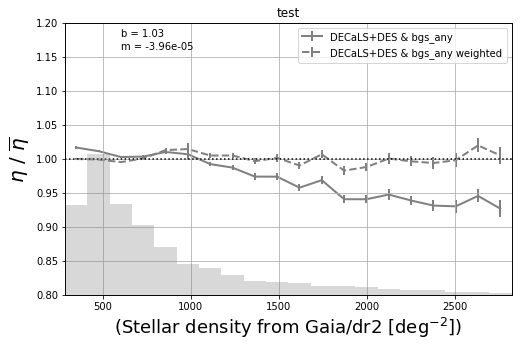

In [12]:
fig    = plt.figure(figsize=(18,5))
gs     = gridspec.GridSpec(1,2,hspace=0.30,wspace=0.25)
isdesi     = (hpdict['isdesi']) & (hpdict['bgsfracarea']>0) #this should be rename as "mainreg"
nx         = 20

plot_sysdens(hpdicttmp=hpdict, namesels=['bgs_any'], regs=[reg], syst='stardens', mainreg=isdesi, xlim=None, n=0, nx=nx, clip=True, 
                         denslims=False, ylab=True, weights=True, fig=fig, gs=gs, title='test', label=True)

In [91]:
#dic WEIGHTED

ws = 1./((-3.96*10**(-5))*hpdict['stardens'] + 1.03)

hpdict_ws = get_dict(cat=cat, pixmapfile=dr8pix, hppix_ran=hppix_ran, hppix_cat=hppix_cat, 
                      maskrand=((rancuts['BS']) & (rancuts['GC']) & (rancuts['LG']) & (rancuts['nobs'])),
                          maskcat=None, 
                             Nranfiles=Nranfiles, ranindesi=ranindesi, catindesi=None, 
                                desifootprint=True, namesels={'bgs_any':20, 'bright':21, 'faint':22}, 
                                  galb=galb, log=True, survey='bgs', ws=ws)

positions and desifotprint DONE...
systematics DONE...
randdens =  15000  ; len randoms =  145754705
bgsfracarea DONE...
regions DONE...
areas DONE...
computing for  north / bgs_any
computing for  north / bright
computing for  north / faint
target densities in north DONE...
computing for  south / bgs_any
computing for  south / bright
computing for  south / faint
target densities in south DONE...
meandens_bgs_any_all = 1429 /deg2
meandens_bgs_any_des = 1416 /deg2
meandens_bgs_any_decals = 1430 /deg2
meandens_bgs_any_north = nan /deg2
meandens_bgs_any_south = 1429 /deg2
meandens_bgs_any_svfields = 1450 /deg2
meandens_bgs_any_svfields_n = nan /deg2
meandens_bgs_any_svfields_s = 1450 /deg2
meandens_bright_all = 849 /deg2
meandens_bright_des = 842 /deg2
meandens_bright_decals = 850 /deg2
meandens_bright_north = nan /deg2
meandens_bright_south = 849 /deg2
meandens_bright_svfields = 856 /deg2
meandens_bright_svfields_n = nan /deg2
meandens_bright_svfields_s = 856 /deg2
meandens_faint_all = 58

In [23]:
from QA import pixhistregs

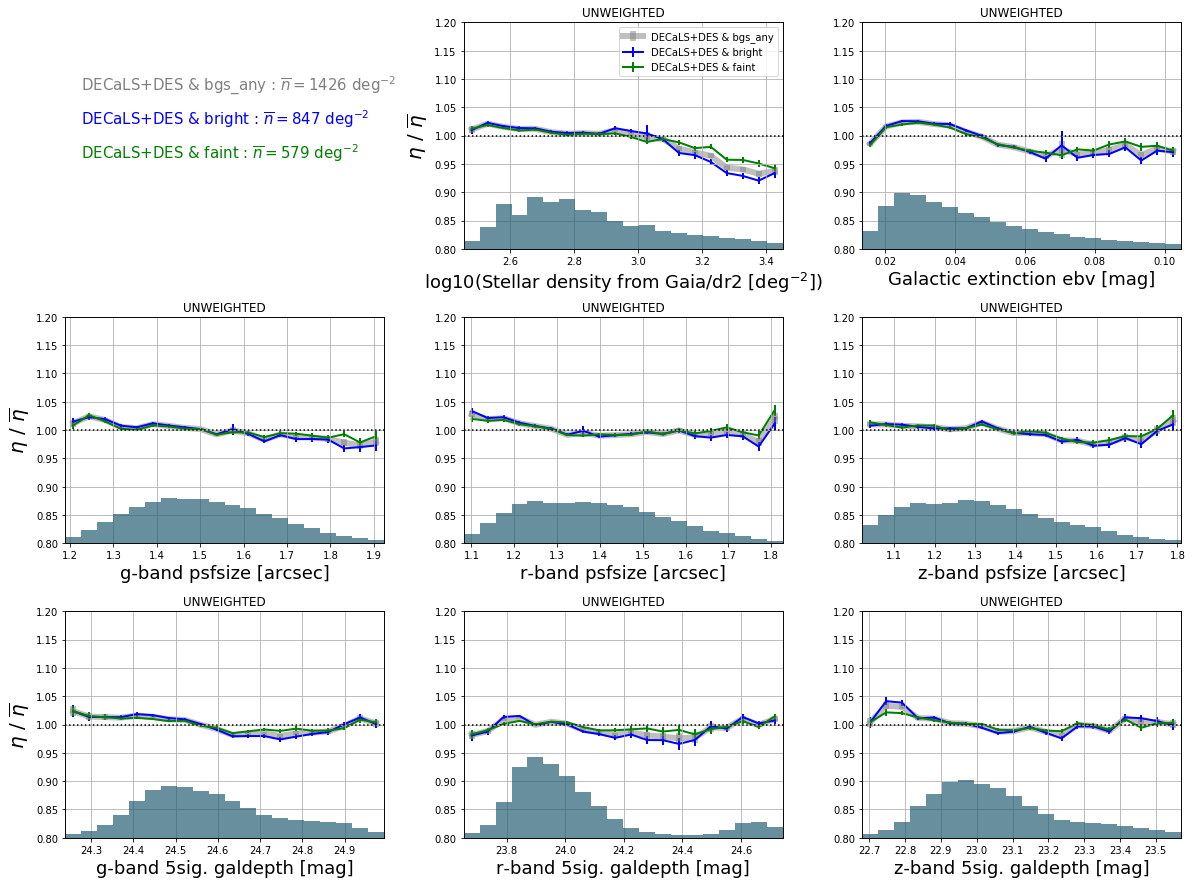

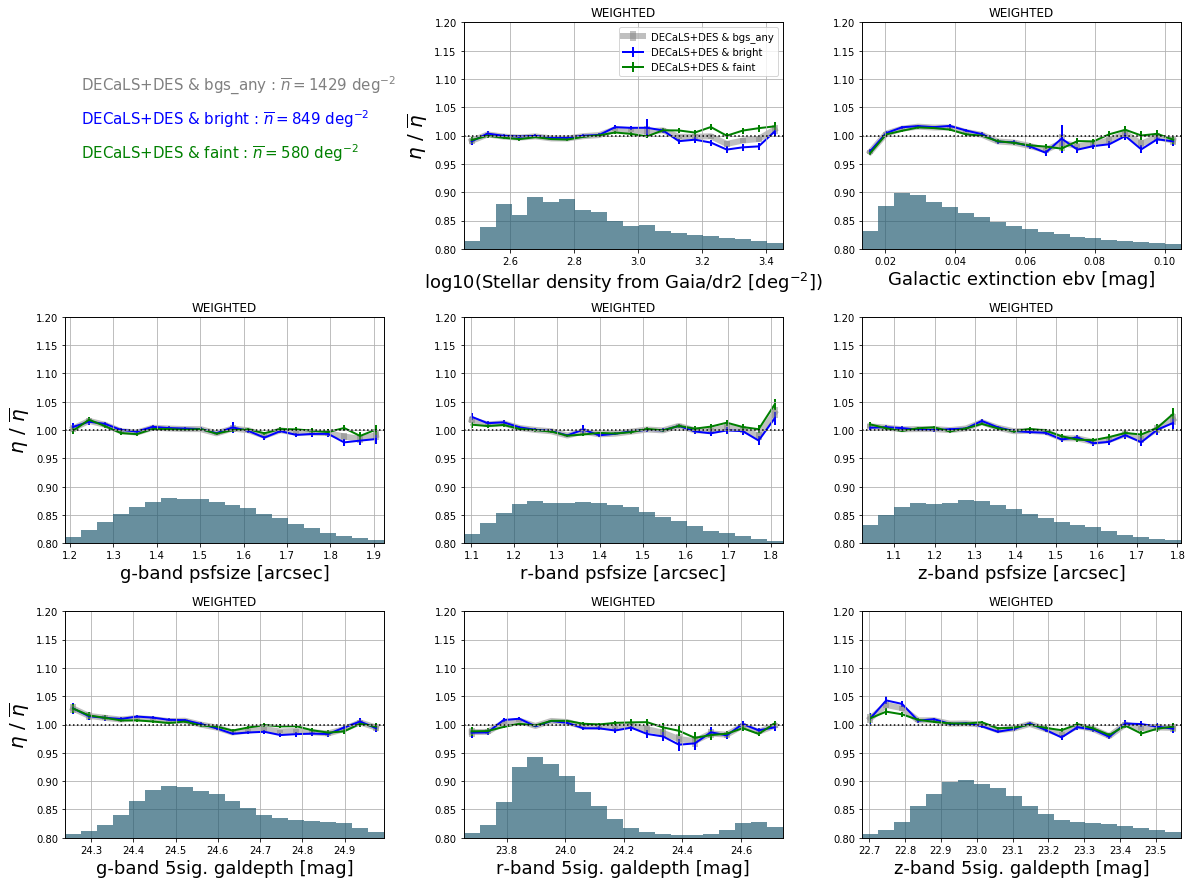

In [95]:
# dr8_south+north : density distributions + systematics

# settings
isdesi     = (hpdict['isdesi']) & (hpdict['bgsfracarea']>0) #this should be rename as "mainreg"
systs      = ['log10_stardens','ebv','psfsize_g', 'psfsize_r', 'psfsize_z','galdepth_g', 'galdepth_r', 'galdepth_z']
nx         = 20
cols       = ['0.5','b','g','r']    
#regs = [reg]
namesels=['bgs_any', 'bright', 'faint']
#

# looping on subselections
#for key, title in zip([None, ws], ['UNWEIGHTED', 'WEIGHTED']):
for key, title in zip([hpdict, hpdict_ws], ['UNWEIGHTED', 'WEIGHTED']):
    
    # systematics
    fig    = plt.figure(figsize=(20,15))
    gs     = gridspec.GridSpec(3,3,hspace=0.30,wspace=0.25)
        
    for i in range(len(systs)+1):
        
        if i == 0:
            axinfo = fig.add_subplot(gs[i])
            # infos
            axinfo.axis('off')
            #axinfo.text(0.5,0.9,namesel,fontsize=20,fontweight='bold',ha='center',transform=axinfo.transAxes)
            tmpy = 0.7
            #for regi,col in zip(regs,cols):
            if reg == 'south':reg_ = 'DECaLS+DES'
            else: reg_ = reg
            for namesel,col in zip(namesels,cols):
                tmpstr = reg_+' & '+namesel+' : '+r'$\overline{n}=$'+'%.0f'%key['meandens_'+namesel+'_'+reg]+r' deg$^{-2}$'
                axinfo.text(0.05,tmpy,tmpstr,color=col,fontsize=15,transform=axinfo.transAxes)
                tmpy  -= 0.15
        else:
            syst = systs[i-1]
            if (i%3==0) or (i==1): ylab=True
            else: ylab = False
            if i == 1: label = True
            else: label = False
            #if title == 'UNWEIGHTED': 
            #    weights = False
            #    onlyweights=False
            #else: 
            #    weights = True
            #    onlyweights=True
                
            plot_sysdens(hpdicttmp=key, namesels=namesels, regs=[reg], syst=syst, mainreg=isdesi, xlim=None, n=i, nx=nx, clip=True, 
                         denslims=False, ylab=ylab, weights=False, fig=fig, gs=gs, label=label, title=title, 
                             ws=None)
    
    # save fig
    fig.savefig('%s/systematics_main_bgs_%s_%s.png' %(pathdir, survey, title), bbox_inches = 'tight', pad_inches = 0)
    print('')
    print('')

### Systematics separated by best model fitted

In [19]:
namesels = {}
for i in ['COMP', 'DEV ', 'EXP ', 'PSF ', 'REX ']:
    namesels[i] = (cat['TYPE'] == i) & (bgs_any)

In [20]:
hpdict_tmp = get_dict(cat=cat, pixmapfile=dr8pix, hppix_ran=hppix_ran, hppix_cat=hppix_cat, 
                      maskrand=((rancuts['BS']) & (rancuts['GC']) & (rancuts['LG']) & (rancuts['nobs'])),
                          maskcat=None, 
                             Nranfiles=Nranfiles, ranindesi=ranindesi, catindesi=None, 
                                desifootprint=True, namesels=namesels, galb=cat_ex['b'], log=True, survey='custom')

positions and desifotprint DONE...
systematics DONE...
randdens =  15000  ; len randoms =  145754705
bgsfracarea DONE...
regions DONE...
areas DONE...
computing for  north / COMP
computing for  north / DEV 
computing for  north / EXP 
computing for  north / PSF 
computing for  north / REX 
target densities in north DONE...
computing for  south / COMP
computing for  south / DEV 
computing for  south / EXP 
computing for  south / PSF 
computing for  south / REX 
target densities in south DONE...
meandens_COMP_all = 31 /deg2
meandens_COMP_des = 50 /deg2
meandens_COMP_decals = 28 /deg2
meandens_COMP_north = nan /deg2
meandens_COMP_south = 31 /deg2
meandens_COMP_svfields = 34 /deg2
meandens_COMP_svfields_n = nan /deg2
meandens_COMP_svfields_s = 34 /deg2
meandens_DEV _all = 630 /deg2
meandens_DEV _des = 650 /deg2
meandens_DEV _decals = 627 /deg2
meandens_DEV _north = nan /deg2
meandens_DEV _south = 630 /deg2
meandens_DEV _svfields = 655 /deg2
meandens_DEV _svfields_n = nan /deg2
meandens_DEV

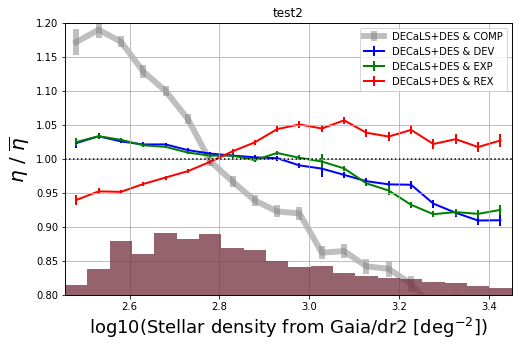

In [27]:
fig    = plt.figure(figsize=(18,5))
gs     = gridspec.GridSpec(1,2,hspace=0.30,wspace=0.25)
isdesi     = (hpdict_tmp['isdesi']) & (hpdict_tmp['bgsfracarea']>0)

plot_sysdens(hpdicttmp=hpdict_tmp, namesels=['COMP', 'DEV ', 'EXP ', 'REX '], regs=[reg], 
                 syst='log10_stardens', mainreg=isdesi, xlim=None, n=0, nx=20, clip=True, 
                         denslims=False, ylab=True, weights=False, fig=fig, gs=gs, title='test2', label=True)

### Systematics separated by rmag bins

In [30]:
namesels = {}
mags = np.linspace(16, 20, 9)
for i in range(len(mags[:-1])):
    namesels['%s_%s' %(str(mags[i]), str(mags[i+1]))] = (cat['RMAG'] > mags[i]) & (cat['RMAG'] < mags[i+1]) & (bgs_any)

In [31]:
namesels.keys()

dict_keys(['16.0_16.5', '16.5_17.0', '17.0_17.5', '17.5_18.0', '18.0_18.5', '18.5_19.0', '19.0_19.5', '19.5_20.0'])

In [32]:
hpdict_tmp = get_dict(cat=cat, pixmapfile=dr8pix, hppix_ran=hppix_ran, hppix_cat=hppix_cat, 
                      maskrand=((rancuts['BS']) & (rancuts['GC']) & (rancuts['LG']) & (rancuts['nobs'])),
                          maskcat=None, 
                             Nranfiles=Nranfiles, ranindesi=ranindesi, catindesi=None, 
                                desifootprint=True, namesels=namesels, galb=cat_ex['b'], log=True, survey='custom')

positions and desifotprint DONE...
systematics DONE...
randdens =  15000  ; len randoms =  145754705
bgsfracarea DONE...
regions DONE...
areas DONE...
computing for  north / 16.0_16.5
computing for  north / 16.5_17.0
computing for  north / 17.0_17.5
computing for  north / 17.5_18.0
computing for  north / 18.0_18.5
computing for  north / 18.5_19.0
computing for  north / 19.0_19.5
computing for  north / 19.5_20.0
target densities in north DONE...
computing for  south / 16.0_16.5
computing for  south / 16.5_17.0
computing for  south / 17.0_17.5
computing for  south / 17.5_18.0
computing for  south / 18.0_18.5
computing for  south / 18.5_19.0
computing for  south / 19.0_19.5
computing for  south / 19.5_20.0
target densities in south DONE...
meandens_16.0_16.5_all = 12 /deg2
meandens_16.0_16.5_des = 12 /deg2
meandens_16.0_16.5_decals = 12 /deg2
meandens_16.0_16.5_north = nan /deg2
meandens_16.0_16.5_south = 12 /deg2
meandens_16.0_16.5_svfields = 11 /deg2
meandens_16.0_16.5_svfields_n = nan 

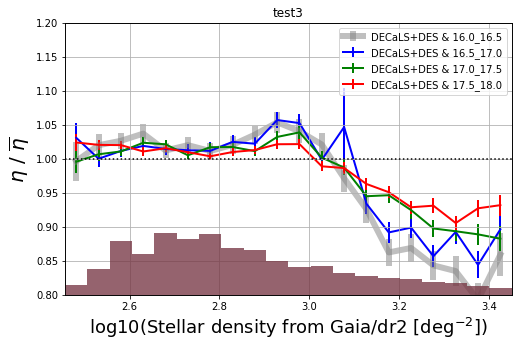

In [33]:
fig    = plt.figure(figsize=(18,5))
gs     = gridspec.GridSpec(1,2,hspace=0.30,wspace=0.25)
isdesi     = (hpdict_tmp['isdesi']) & (hpdict_tmp['bgsfracarea']>0)

plot_sysdens(hpdicttmp=hpdict_tmp, namesels=['16.0_16.5', '16.5_17.0', '17.0_17.5', '17.5_18.0'], regs=[reg], 
                 syst='log10_stardens', mainreg=isdesi, xlim=None, n=0, nx=20, clip=True, 
                         denslims=False, ylab=True, weights=False, fig=fig, gs=gs, title='test3', label=True)

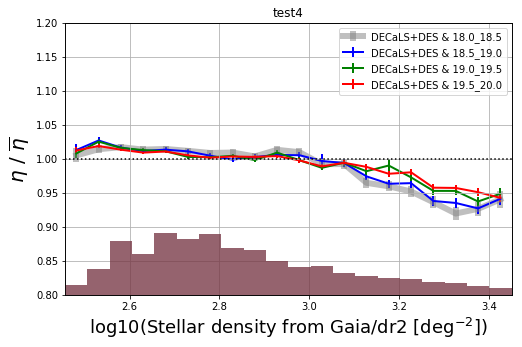

In [34]:
fig    = plt.figure(figsize=(18,5))
gs     = gridspec.GridSpec(1,2,hspace=0.30,wspace=0.25)
isdesi     = (hpdict_tmp['isdesi']) & (hpdict_tmp['bgsfracarea']>0)

plot_sysdens(hpdicttmp=hpdict_tmp, namesels=['18.0_18.5', '18.5_19.0', '19.0_19.5', '19.5_20.0'], regs=[reg], 
                 syst='log10_stardens', mainreg=isdesi, xlim=None, n=0, nx=20, clip=True, 
                         denslims=False, ylab=True, weights=False, fig=fig, gs=gs, title='test4', label=True)

## AEN vs G-rr star-galaxy classification in GAIA

Tractor force to fit as PSF the GAIA objects that satisfy the following conditions:

* For $G<19$: astrometric_excess_noise $< 10^{0.5}$, 

* For $G≥19$: astrometric_excess_noise $ < 10^{0.5+0.2(G−19)}$.
    
G is the GAIA photometric $G$-band and the astrometric excess noise ($AEN$) is the...
Those PSF that are in GAIA are treated as Stars according to TRACTOR and the GAIA objects that do not fulfill that condition are treated as GALAXIES. This is different to the way we do star-galaxy separation for BGS, we use GAIA but rather than look at the $AEN$ we look at the colour distribution $G-rr$.

The PSF GAIA objects (from above definition) are treated differently than other PSF objects and they have a local fitting, the problem is that maybe those are not stars and might be galaxies instead that photometry is being altered by this local fitting.

Here we are going to find out what are the differences between our star-galaxy classification and the one above for GAIA objects.
We're going to:

* $Grr$ distributions for $Grr$ class and $AEN$ class:
    * All
    * TRACTOR PSF
    * TRACTOR No PSF
* Heat maps
* Venn diagram's
* Galleries of mismatches divided in `TRACTOR PSF` and `TRACTOR non-PSF`:
    * Stars with $Grr$ class and Galaxies with $AEN$ class
    * Galaxies with $Grr$ class and Stars with $AEN$ class

In [ ]:
inGAIA = (cat['REF_CAT'] == 'G2') & (cat['RMAG'] < 20)
grr_gal = ((cat['BGSBITS'] & 2**(6)) != 0) & (cat['RMAG'] < 20)
grr_stars = ((cat['BGSBITS'] & 2**(6)) == 0) & (cat['RMAG'] < 20)
AEN_star, AEN_gal = gaiaAEN(inGAIA=inGAIA, size=len(cat['RA']), G=cat['G'], AEN=cat['AEN'])
PSF = (cat['TYPE'] == 'PSF ')

#inGAIA2 = (cat['G'] != 0)

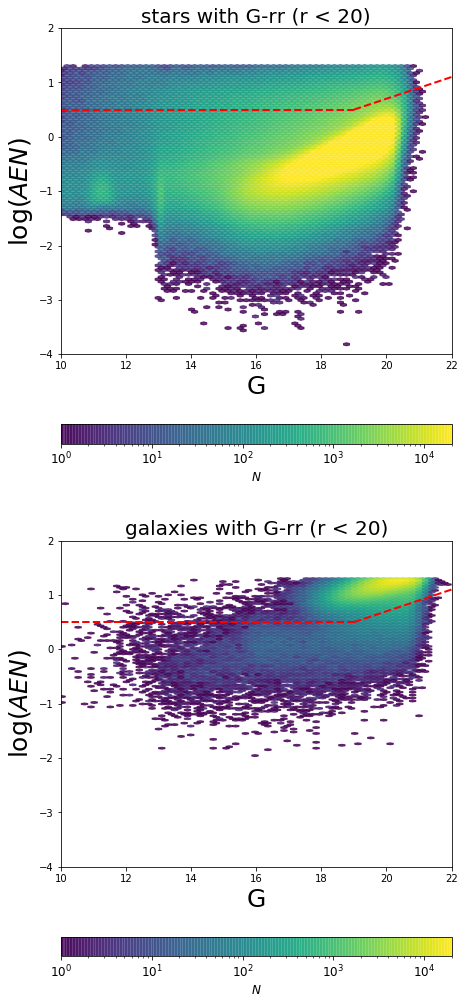

In [76]:
#
coord = {'G':cat['G'], r'$\log(AEN)$':np.log10(cat['AEN'])}
#masks = [(grr_stars) & (inGAIA) & (cat['RMAG'] < 14), (grr_gal) & (inGAIA) & (cat['RMAG'] < 14)]
masks = [(grr_stars) & (inGAIA), (grr_gal) & (inGAIA)]
titles = ['stars with G-rr (r < 20)', 'galaxies with G-rr (r < 20)']
vmin, vmax = 1, 20000
    
fig    = plt.figure(figsize=(7,9*len(masks)))
gs     = gridspec.GridSpec(len(masks), 1,hspace=0.1,wspace=0.10)
    
for i, mask in enumerate(masks):
        
    #if (i%len(masks)==0): xlab=True
    #else: xlab = False
    #if morpho == 'PSF ': vmax = None
        
    #morphomask = cat['TYPE'] == morpho
    hexbin(coord=coord, catmask=mask, n=i, bins='log', title=titles[i], cmap='viridis', xlab=True,
               ylab=True, vline=None, hline=None, fig=fig, gs=gs, vmin=vmin, vmax=vmax, mincnt=1, fmcline=False, 
                   file=None, area=None, xlim=[10, 22], ylim=[-4, 2], cbar='horizontal')
    
    #if i == 0:
    #    x, y = coord.keys()
    #    mask1 = (gaia_star) & (dr8_gama) & (dr8_z > 0.002) & (bgs)
    #    mask2 = (gaia_star) & (dr8_gama) & (dr8_z > 0.002) & (~bgs)
    #    plt.scatter(coord[x][mask2], coord[y][mask2], s=2, c='royalblue', label=r'Not in BGS')
    #    plt.scatter(coord[x][mask1], coord[y][mask1], s=2, c='k', label=r'in BGS')
    #    plt.legend()
    
    x_N1 = np.linspace(10, 19, 4)
    x_N2 = np.linspace(19, 22, 4)
    plt.plot(x_N1, x_N1*0+0.5, color='r', ls='--', lw=2)
    plt.plot(x_N2, 0.5 + 0.2*(x_N2 - 19.), color='r', ls='--', lw=2)

file = pathdir+'/G_logAEN'
fig.savefig(file+'.png', bbox_inches = 'tight', pad_inches = 0)

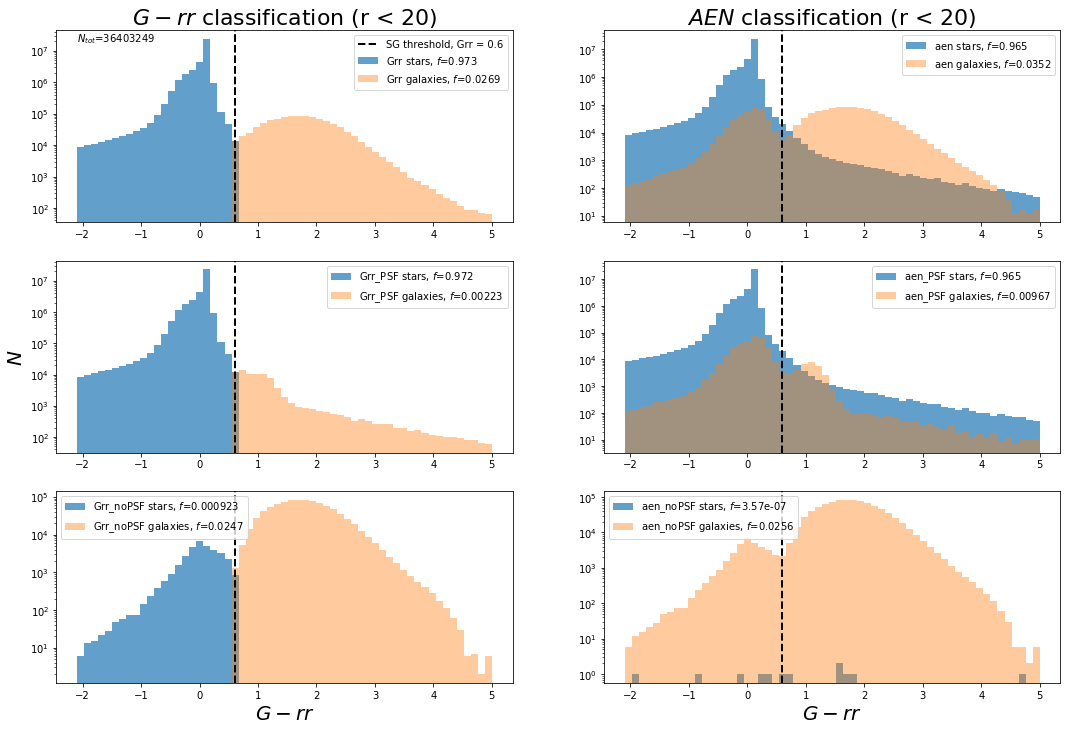

In [77]:
#
fig = plt.figure(figsize=(18,12))

log = True
Grr = cat['G'] - flux_to_mag(cat['FLUX_R'])

classes = {'stars_Grr':(grr_stars) & (inGAIA), 'gal_Grr':(grr_gal) & (inGAIA), 'stars_aen': (AEN_star) & (cat['RMAG'] < 20), 'gal_aen':(AEN_gal) & (cat['RMAG'] < 20), 
              'stars_Grr_PSF':(grr_stars) & (inGAIA) & (PSF), 'gal_Grr_PSF':(grr_gal) & (inGAIA) & (PSF),
                  'stars_aen_PSF':(AEN_star) & (PSF) & (cat['RMAG'] < 20), 'gal_aen_PSF':(AEN_gal) & (PSF) & (cat['RMAG'] < 20),
                      'stars_Grr_noPSF':(grr_stars) & (inGAIA) & (~PSF), 'gal_Grr_noPSF':(grr_gal) & (inGAIA) & (~PSF),
                          'stars_aen_noPSF':(AEN_star) & (~PSF) & (cat['RMAG'] < 20), 'gal_aen_noPSF':(AEN_gal) & (~PSF) & (cat['RMAG'] < 20)}

for i, j in enumerate(['Grr', 'aen', 'Grr_PSF', 'aen_PSF', 'Grr_noPSF', 'aen_noPSF']):

    XS = (classes['stars_' + j])
    XG = (classes['gal_' + j])
    tot_gaia = np.sum((inGAIA))

    plt.subplot(3, 2, i+1)
    
    if i == 0:
        plt.title(r'$G-rr$ classification (r < 20)', size=22)
    if i == 1:
        plt.title(r'$AEN$ classification (r < 20)', size=22)
    
    bins = np.linspace(-2.1, 5, 60)
        
    plt.hist(Grr[XS], bins=bins, log=log, alpha=0.7, label='%s stars, $f$=%2.3g' %(j, np.sum(XS)/tot_gaia))
    plt.hist(Grr[XG], bins=bins, log=log, alpha=0.4, label='%s galaxies, $f$=%2.3g' %(j, np.sum(XG)/tot_gaia))
    if i == 0:
        plt.axvline(0.6, ls='--', lw=2, c='k', label='SG threshold, Grr = 0.6')
        plt.text(-2.1, 2*10**7, '$N_{tot}$=%s' %(tot_gaia))
    plt.axvline(0.6, ls='--', lw=2, c='k')
    if (i == 4) or (i == 5):
        plt.xlabel(r'$G-rr$', size=20)
    if i == 2:
        plt.ylabel(r'$N$', size=20)    
    plt.legend()

plt.show()
filename = '%s/gaia_Grr_comparison_with_aen' %(pathdir)
fig.savefig(filename+'.png') #bbox_inches = 'tight', pad_inches = 0


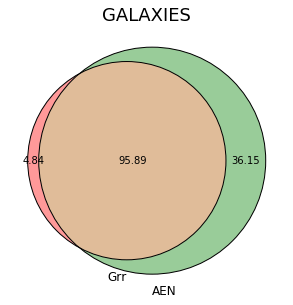

In [81]:
from matplotlib_venn import venn2, venn2_circles

fig = plt.figure(figsize=(5,5))

sf = 2
area = hpdict0['bgsarea_south']

a = classes['gal_Grr']
b = classes['gal_aen']
c = (a) & (b)

a1 = round(((np.sum(a) - np.sum(c))/area), sf)
b1 = round(((np.sum(b) - np.sum(c))/area), sf)
c1 = round(np.sum(c)/area, sf)

plt.title(r'GALAXIES', size=18)
labels = ('Grr', 'AEN')
   
venn2([a1, b1, c1], set_labels = labels)
c=venn2_circles([a1, b1, c1], linestyle='solid', linewidth=1, color="k")

filename = '%s/venn_gaia_Grr_comparison_with_aen' %(pathdir)
fig.savefig(filename+'.png', bbox_inches = 'tight', pad_inches = 0) 


# DEV ZONE

In [68]:
#bgslist = ['BS', 'LG', 'GC', 'nobs', 'FMC2', 'CC', 'QC_FM', 'QC_FI', 'QC_FF', 'QC_IVAR']
bgsbut20 = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['QC_FM','QC_FI','QC_FF','QC_IVAR', 'FMC2', 'CC', 'nobs', 'BS', 'LG', 'GC'], bgsmask=bgsmask(), rlimit=20)
bgsbut201 = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['QC_FM','QC_FI','QC_FF','QC_IVAR', 'FMC2', 'CC', 'nobs', 'BS', 'LG', 'GC'], bgsmask=bgsmask(), rlimit=20.1)
bgsbut205 = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['QC_FM','QC_FI','QC_FF','QC_IVAR', 'FMC2', 'CC', 'nobs', 'BS', 'LG', 'GC'], bgsmask=bgsmask(), rlimit=20.5)
bgsbut207 = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['QC_FM','QC_FI','QC_FF','QC_IVAR', 'FMC2', 'CC', 'nobs', 'BS', 'LG', 'GC'], bgsmask=bgsmask(), rlimit=20.7)
#bgsbutCC = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['CC'], bgsmask=bgsmask())
#bgsbutFMC2 = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['FMC2'], bgsmask=bgsmask())
#bgsbutBSLG = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['BS', 'LG'], bgsmask=bgsmask())

In [43]:
bgs_any = ((cat['BGSBITS'] & 2**(20)) != 0)

In [69]:
namesels = {}
#namesels['bgs_any'] = bgs_any
namesels['bgsbut20'] = bgsbut20
namesels['bgsbut201'] = bgsbut201
namesels['bgsbut205'] = bgsbut205
namesels['bgsbut207'] = bgsbut207

In [70]:
#dic with default BGS selection and in DESI footprint
#maskrand=((rancuts['BS']) & (rancuts['GC']) & (rancuts['LG']) & (rancuts['nobs']))
hpdict_tmp = get_dict(cat=cat, pixmapfile=dr8pix, hppix_ran=hppix_ran, hppix_cat=hppix_cat, 
                      maskrand=None,
                          maskcat=None, 
                             Nranfiles=Nranfiles, ranindesi=ranindesi, catindesi=None, 
                                desifootprint=True, namesels=namesels, galb=galb, log=True, survey='custom')

positions and desifotprint DONE...
systematics DONE...
randdens =  15000  ; len randoms =  145754705
bgsfracarea DONE...
regions DONE...
areas DONE...
computing for  north / bgsbut20
computing for  north / bgsbut201
computing for  north / bgsbut205
computing for  north / bgsbut207
target densities in north DONE...
computing for  south / bgsbut20
computing for  south / bgsbut201
computing for  south / bgsbut205
computing for  south / bgsbut207
target densities in south DONE...
meandens_bgsbut20_all = 1452 /deg2
meandens_bgsbut20_des = 1442 /deg2
meandens_bgsbut20_decals = 1453 /deg2
meandens_bgsbut20_north = nan /deg2
meandens_bgsbut20_south = 1452 /deg2
meandens_bgsbut20_svfields = 1466 /deg2
meandens_bgsbut20_svfields_n = nan /deg2
meandens_bgsbut20_svfields_s = 1466 /deg2
meandens_bgsbut201_all = 1608 /deg2
meandens_bgsbut201_des = 1596 /deg2
meandens_bgsbut201_decals = 1610 /deg2
meandens_bgsbut201_north = nan /deg2
meandens_bgsbut201_south = 1608 /deg2
meandens_bgsbut201_svfields =

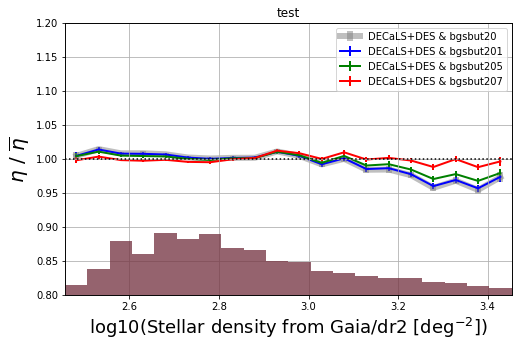

In [71]:
fig    = plt.figure(figsize=(18,5))
gs     = gridspec.GridSpec(1,2,hspace=0.30,wspace=0.25)
isdesi     = (hpdict_tmp['isdesi']) & (hpdict_tmp['bgsfracarea']>0)

plot_sysdens(hpdicttmp=hpdict_tmp, namesels=['bgsbut20', 'bgsbut201', 'bgsbut205', 'bgsbut207'], regs=[reg], 
                 syst='log10_stardens', mainreg=isdesi, xlim=None, n=0, nx=20, clip=True, 
                         denslims=False, ylab=True, weights=False, fig=fig, gs=gs, title='test', label=True)

#plot_sysdens(hpdicttmp=hpdict_tmp, namesels=[ 'bgs_19.0_19.5', 'bgs_19.5_20.0'], regs=[reg], syst='log10_stardens', mainreg=isdesi, xlim=None, n=1, nx=nx, clip=True, 
#                         denslims=False, ylab=True, weights=False, fig=fig, gs=gs, title='test', label=True)


In [73]:
#bgslist = ['BS', 'LG', 'GC', 'nobs', 'FMC2', 'CC', 'QC_FM', 'QC_FI', 'QC_FF', 'QC_IVAR']
bgsbut20 = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=None, bgsmask=bgsmask(), rlimit=20)
bgsbut201 = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=None, bgsmask=bgsmask(), rlimit=20.1)
bgsbut205 = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=None, bgsmask=bgsmask(), rlimit=20.5)
bgsbut207 = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=None, bgsmask=bgsmask(), rlimit=20.7)

In [74]:
namesels = {}
namesels['bgsbut20'] = bgsbut20
namesels['bgsbut201'] = bgsbut201
namesels['bgsbut205'] = bgsbut205
namesels['bgsbut207'] = bgsbut207

In [75]:
#dic with default BGS selection and in DESI footprint
#maskrand=((rancuts['BS']) & (rancuts['GC']) & (rancuts['LG']) & (rancuts['nobs']))
hpdict_tmp = get_dict(cat=cat, pixmapfile=dr8pix, hppix_ran=hppix_ran, hppix_cat=hppix_cat, 
                      maskrand=((rancuts['BS']) & (rancuts['GC']) & (rancuts['LG']) & (rancuts['nobs'])),
                          maskcat=None, 
                             Nranfiles=Nranfiles, ranindesi=ranindesi, catindesi=None, 
                                desifootprint=True, namesels=namesels, galb=galb, log=True, survey='custom')

positions and desifotprint DONE...
systematics DONE...
randdens =  15000  ; len randoms =  145754705
bgsfracarea DONE...
regions DONE...
areas DONE...
computing for  north / bgsbut20
computing for  north / bgsbut201
computing for  north / bgsbut205
computing for  north / bgsbut207
target densities in north DONE...
computing for  south / bgsbut20
computing for  south / bgsbut201
computing for  south / bgsbut205
computing for  south / bgsbut207
target densities in south DONE...
meandens_bgsbut20_all = 1426 /deg2
meandens_bgsbut20_des = 1430 /deg2
meandens_bgsbut20_decals = 1425 /deg2
meandens_bgsbut20_north = nan /deg2
meandens_bgsbut20_south = 1426 /deg2
meandens_bgsbut20_svfields = 1437 /deg2
meandens_bgsbut20_svfields_n = nan /deg2
meandens_bgsbut20_svfields_s = 1437 /deg2
meandens_bgsbut201_all = 1578 /deg2
meandens_bgsbut201_des = 1583 /deg2
meandens_bgsbut201_decals = 1578 /deg2
meandens_bgsbut201_north = nan /deg2
meandens_bgsbut201_south = 1578 /deg2
meandens_bgsbut201_svfields =

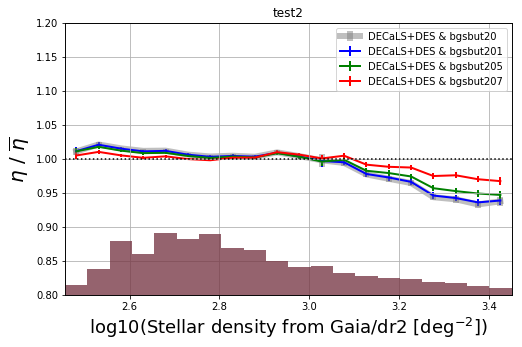

In [76]:
fig    = plt.figure(figsize=(18,5))
gs     = gridspec.GridSpec(1,2,hspace=0.30,wspace=0.25)
isdesi     = (hpdict_tmp['isdesi']) & (hpdict_tmp['bgsfracarea']>0)

plot_sysdens(hpdicttmp=hpdict_tmp, namesels=['bgsbut20', 'bgsbut201', 'bgsbut205', 'bgsbut207'], regs=[reg], 
                 syst='log10_stardens', mainreg=isdesi, xlim=None, n=0, nx=20, clip=True, 
                         denslims=False, ylab=True, weights=False, fig=fig, gs=gs, title='test2', label=True)

#plot_sysdens(hpdicttmp=hpdict_tmp, namesels=[ 'bgs_19.0_19.5', 'bgs_19.5_20.0'], regs=[reg], syst='log10_stardens', mainreg=isdesi, xlim=None, n=1, nx=nx, clip=True, 
#                         denslims=False, ylab=True, weights=False, fig=fig, gs=gs, title='test', label=True)


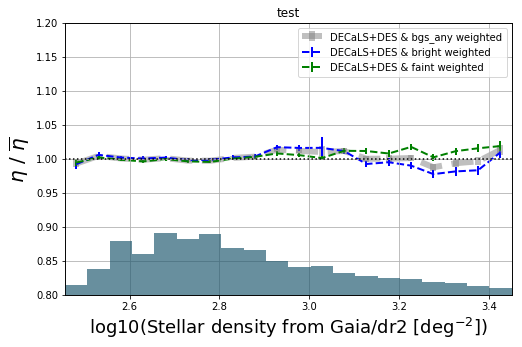

In [80]:
#
ws = 1./((-3.96*10**(-5))*hpdict['stardens'] + 1.03)

fig    = plt.figure(figsize=(18,5))
gs     = gridspec.GridSpec(1,2,hspace=0.30,wspace=0.25)

plot_sysdens(hpdicttmp=hpdict, namesels=['bgs_any', 'bright', 'faint'], regs=[reg], syst='log10_stardens', mainreg=isdesi, xlim=None, n=0, nx=nx, clip=True, 
                         denslims=False, ylab=True, weights=True, fig=fig, gs=gs, title='test', label=True, ws=ws, onlyweights=True)

In [88]:
hpdict['meandens_bgs_any_south']

1425.646415390457

In [89]:
hpdict_tmp['meandens_bgs_any_south']

1432.660001909052

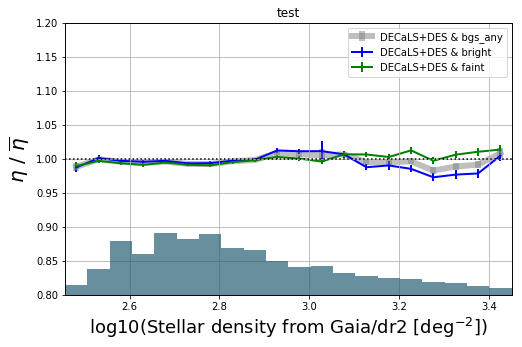

In [90]:
#
#ws = 1./((-3.96*10**(-5))*hpdict['stardens'] + 1.03)

fig    = plt.figure(figsize=(18,5))
gs     = gridspec.GridSpec(1,2,hspace=0.30,wspace=0.25)

plot_sysdens(hpdicttmp=hpdict_tmp, namesels=['bgs_any', 'bright', 'faint'], regs=[reg], syst='log10_stardens', mainreg=isdesi, xlim=None, n=0, nx=nx, clip=True, 
                         denslims=False, ylab=True, weights=False, fig=fig, gs=gs, title='test', label=True, ws=None, onlyweights=False)

In [53]:
bgs_any = ((cat['BGSBITS'] & 2**(20)) != 0)
namesels = {}
mags = [15, 18, 18.5, 19.0, 19.5, 20.0]
for num,i in enumerate(mags[:-1]):
    namesels['bgs_%s_%s' %(str(mags[num]), str(mags[num+1]))] = (bgs_any) & (cat['RMAG'] > mags[num]) & (cat['RMAG'] < mags[num+1])
    

In [55]:
#dic with default BGS selection and in DESI footprint
hpdict_tmp = get_dict(cat=cat, pixmapfile=dr8pix, hppix_ran=hppix_ran, hppix_cat=hppix_cat, 
                      maskrand=((rancuts['BS']) & (rancuts['GC']) & (rancuts['LG']) & (rancuts['nobs'])),
                          maskcat=None, 
                             Nranfiles=Nranfiles, ranindesi=ranindesi, catindesi=None, 
                                desifootprint=True, namesels=namesels, galb=galb, log=True, survey='custom')

positions and desifotprint DONE...
systematics DONE...
randdens =  15000  ; len randoms =  145754705
bgsfracarea DONE...
regions DONE...
areas DONE...
computing for  north / bgs_15_18
computing for  north / bgs_18_18.5
computing for  north / bgs_18.5_18.5
computing for  north / bgs_18.5_19.0
computing for  north / bgs_19.0_19.5
computing for  north / bgs_19.5_20.0
target densities in north DONE...
computing for  south / bgs_15_18
computing for  south / bgs_18_18.5
computing for  south / bgs_18.5_18.5
computing for  south / bgs_18.5_19.0
computing for  south / bgs_19.0_19.5
computing for  south / bgs_19.5_20.0
target densities in south DONE...
meandens_bgs_15_18_all = 154 /deg2
meandens_bgs_15_18_des = 153 /deg2
meandens_bgs_15_18_decals = 154 /deg2
meandens_bgs_15_18_north = nan /deg2
meandens_bgs_15_18_south = 154 /deg2
meandens_bgs_15_18_svfields = 151 /deg2
meandens_bgs_15_18_svfields_n = nan /deg2
meandens_bgs_15_18_svfields_s = 151 /deg2
meandens_bgs_18_18.5_all = 124 /deg2
meande

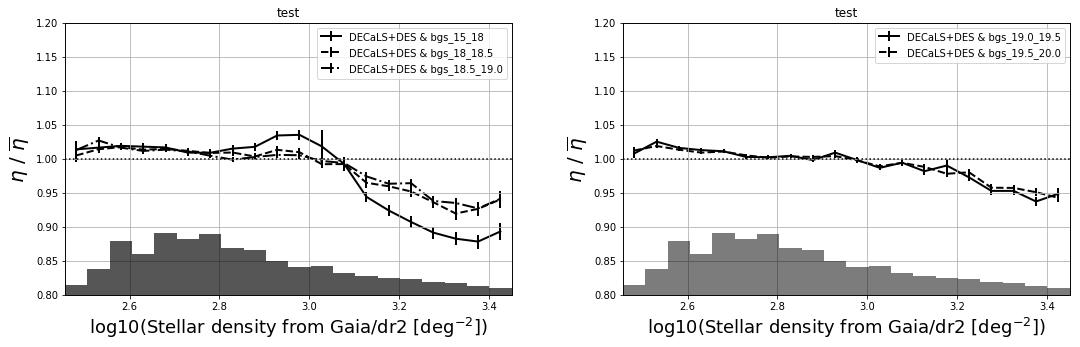

In [60]:
fig    = plt.figure(figsize=(18,5))
gs     = gridspec.GridSpec(1,2,hspace=0.30,wspace=0.25)

plot_sysdens(hpdicttmp=hpdict_tmp, namesels=['bgs_15_18', 'bgs_18_18.5', 'bgs_18.5_19.0'], regs=[reg], syst='log10_stardens', mainreg=isdesi, xlim=None, n=0, nx=nx, clip=True, 
                         denslims=False, ylab=True, weights=False, fig=fig, gs=gs, title='test', label=True)

plot_sysdens(hpdicttmp=hpdict_tmp, namesels=[ 'bgs_19.0_19.5', 'bgs_19.5_20.0'], regs=[reg], syst='log10_stardens', mainreg=isdesi, xlim=None, n=1, nx=nx, clip=True, 
                         denslims=False, ylab=True, weights=False, fig=fig, gs=gs, title='test', label=True)


In [ ]:
bgs_bright = ((cat['BGSBITS'] & 2**(21)) != 0)
bgs_faint = ((cat['BGSBITS'] & 2**(22)) != 0)
bgs_any = ((cat['BGSBITS'] & 2**(20)) != 0)